In [1]:
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# qqplot
import statsmodels.api as sm
import pylab as py

from scipy.stats import mannwhitneyu,wilcoxon,spearmanr

In [2]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

In [3]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [4]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# Load data

In [5]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [120]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})

# Convert checkEnd to integer
data_choice_level["checkEnd"] = pd.to_numeric(data_choice_level["checkEnd"])
data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

In [121]:
data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

# add branching-node RT to puzzle data
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

for i in range(len(subjects_chosen)): #
    index_chosen = puzzleID_order_data.index[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])]
    puzzleID_order_data.loc[index_chosen,'RT_branching'] = RT_branching[i]
puzzleID_order_data['RT_branching'] = puzzleID_order_data['RT_branching']/1000

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)


In [122]:
# undo condition
# select the data before the very first undo or submit
data_subset_before1undo_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]     

        for i in range(len(dat_sbj_pzi)):
            if (dat_sbj_pzi.iloc[i]['undo'] != 1)&(dat_sbj_pzi.iloc[i]['submit'] != 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
            elif (dat_sbj_pzi.iloc[i]['undo'] == 1)|(dat_sbj_pzi.iloc[i]['submit'] == 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
                break

data_subset_before1undo = sc_data_choice_level.loc[data_subset_before1undo_index,:]

In [123]:
# undo condition
# select the data before the very first undo only
data_subset_before1undoonly_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]   
        temp_list = []  

        for i in range(len(dat_sbj_pzi)):
            if dat_sbj_pzi.iloc[i]['undo'] != 1:
                temp_list.append(dat_sbj_pzi.index[i])
            elif dat_sbj_pzi.iloc[i]['undo'] == 1:
                data_subset_before1undoonly_index.extend(temp_list)
                break

data_subset_before1undoonly = sc_data_choice_level.loc[data_subset_before1undoonly_index,:]

# Map characteristics - MAS (supp)

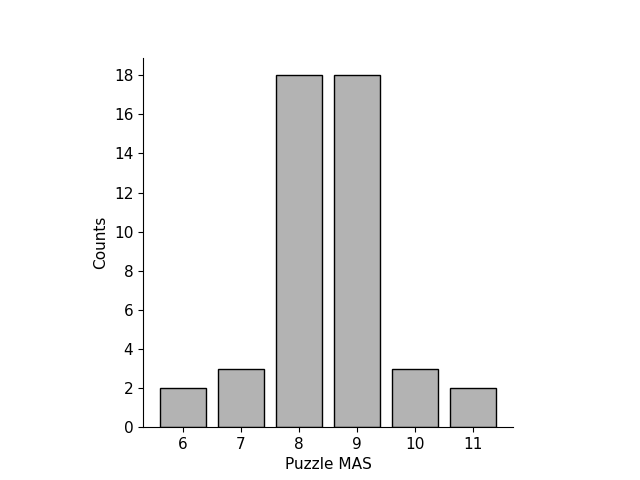

In [275]:
%matplotlib widget

n_mas = single_condition_data[single_condition_data.subjects==2].groupby(['mas'])['mas'].count() # only undo condition

fig, axs = plt.subplots(1, 1)
axs.bar(range(6,12), n_mas,
        color = (.7,.7,.7),
        edgecolor = 'k')## puzzle MAS

### histogram of MAS/remaining budget, numFullUndo',)
axs.set_ylabel('Counts') 
axs.set_yticks(list(range(0, 20, 2)))
axs.set_xlabel('Puzzle MAS')
# change size ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')
#plt.show()
fig.savefig(out_dir + 'count_mas_puzzle.png', dpi=300, bbox_inches='tight')

# Undo Initiation

## Probability of undo - error

### Prepare data

#### Previous path type

In [33]:
# only first undo
puzzle_error = sc_data_choice_level['allMAS'] - sc_data_choice_level['currMas']
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = puzzle_error.index[(puzzle_error == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo", "allMAS"]]
undo_noerror["currNumCities"] = sc_data_choice_level.loc[index_noerror, "currNumCities"].values
undo_noerror_avg = undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = puzzle_error.index[(puzzle_error != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo", "allMAS"]]
undo_error["currNumCities"] = sc_data_choice_level.loc[index_error, "currNumCities"].values
undo_error_avg = undo_error.groupby(["subjects"])['undo'].mean()

print(len(undo_noerror_avg))
print(len(undo_error_avg))

undo_noerror.groupby(["currNumCities", "allMAS","subjects"])["undo"].mean().groupby(["currNumCities", "allMAS"]).count()
undo_error.groupby(["currNumCities", "allMAS","subjects"])["undo"].mean().groupby(["currNumCities", "allMAS"]).count()

100
100


currNumCities  allMAS
1              6          35
               7          79
               8         100
               9         100
               10         72
               11         73
2              6          52
               7          88
               8         100
               9         100
               10         79
               11         81
3              6          63
               7          88
               8         100
               9         100
               10         81
               11         78
4              6          61
               7          98
               8         100
               9         100
               10         85
               11         80
5              6          56
               7          99
               8          99
               9         100
               10         86
               11         80
6              7          93
               8         100
               9         100
               10    

#### Previous move type

In [31]:
# only first undo
# index before undo/not undo, but the possibility of undo cannot be 0
index_noerror = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] == 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
move_undo_noerror = sc_data_choice_level.loc[index_noerror+1, ["subjects", "undo", "allMAS"]]
move_undo_noerror["currNumCities"] = sc_data_choice_level.loc[index_noerror, "currNumCities"].values
move_undo_noerror_avg = move_undo_noerror.groupby(["subjects"])['undo'].mean()

# index before undo/not undo, but the possibility of undo cannot be 0
index_error = sc_data_choice_level.index[(sc_data_choice_level['severityOfErrors'] != 0)&(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
move_undo_error = sc_data_choice_level.loc[index_error+1, ["subjects", "undo", "allMAS"]]
move_undo_error["currNumCities"] = sc_data_choice_level.loc[index_error, "currNumCities"].values
move_undo_error_avg = move_undo_error.groupby(["subjects"])['undo'].mean()

print(len(move_undo_noerror_avg))
print(len(move_undo_error_avg))


100
100


### Hit/false alarm box plot

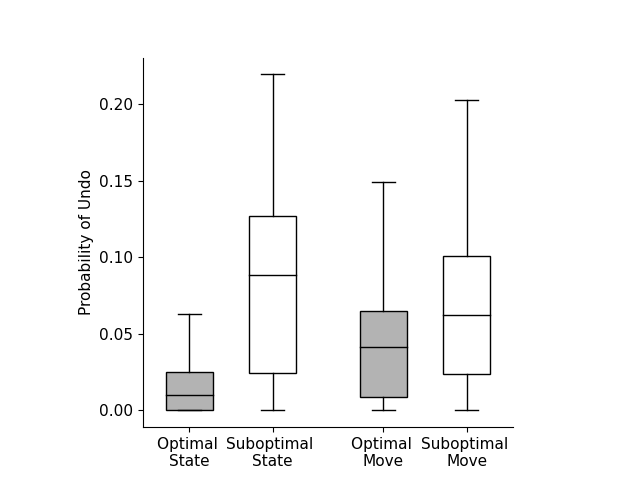

In [371]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# box plot
bx = axs.boxplot([undo_noerror_avg, undo_error_avg,
             move_undo_noerror_avg, move_undo_error_avg],
                widths=0.5,
                positions =[1,1.9,3.1,4],
                patch_artist=True,
                showfliers=False,
                boxprops=dict(color='k'),
                whiskerprops=dict(color='k'),
                capprops=dict(color='k'),
                medianprops=dict(color='k'))

colors = [(.7,.7,.7),'w',(.7,.7,.7),'w']
for patch, color in zip(bx['boxes'], colors):
    patch.set_facecolor(color)

axs.set_ylabel('Probability of Undo')
axs.set_xticks([1,1.9,3.1,4])
axs.set_xticklabels(labels = ['Optimal \nState',
                              'Suboptimal \nState',
                              'Optimal \nMove',
                              'Suboptimal \nMove'])#,fontsize=18

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'undo_all_type.png', dpi=300, bbox_inches='tight')

0.02175728540992308
0.0650974700558826


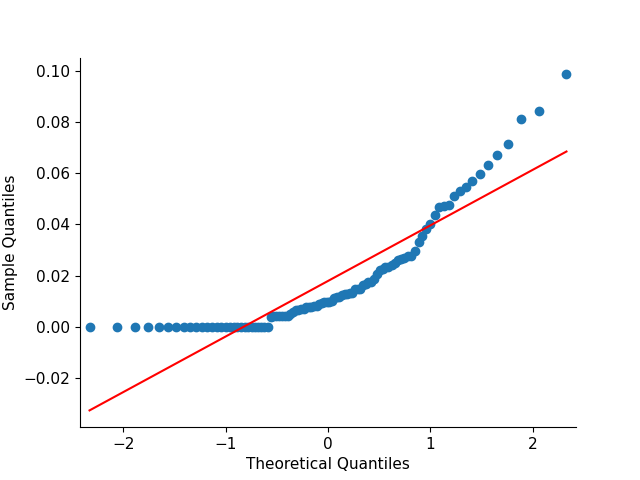

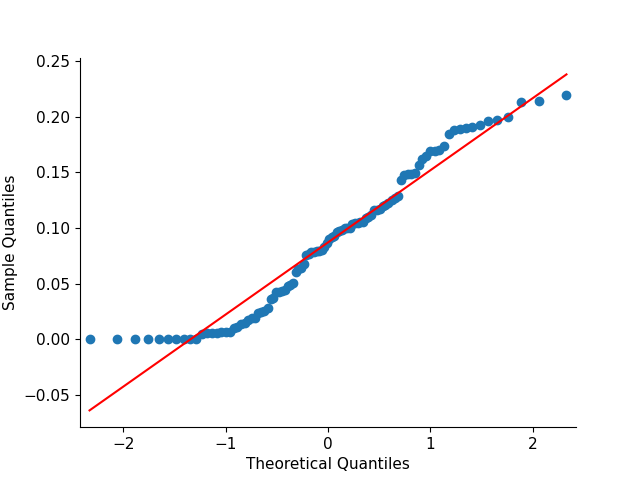

0.038925416137539186
0.05806890338994977


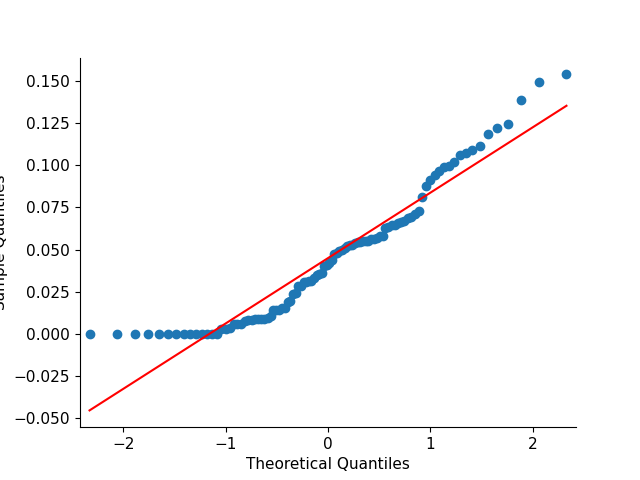

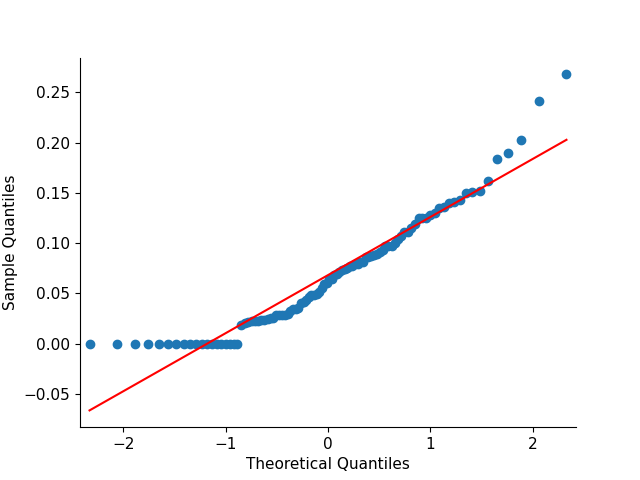

In [279]:
# run 2-independent-sample t test
## check variance
print(np.std(undo_noerror_avg, ddof=1))
print(np.std(undo_error_avg, ddof=1))
## check normality
sm.qqplot(undo_noerror_avg, line='s')
py.show()
sm.qqplot(undo_error_avg, line='s')
py.show()

# run 2-independent-sample t test
## check variance
print(np.std(move_undo_noerror_avg, ddof=1))
print(np.std(move_undo_error_avg, ddof=1))
## check normality
sm.qqplot(move_undo_noerror_avg, line='s')
py.show()
sm.qqplot(move_undo_error_avg, line='s')
py.show()

In [280]:
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
print(stat1, p1)
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
stat1, p1 = wilcoxon(move_undo_noerror_avg, move_undo_error_avg, alternative = 'less')
print(stat1, p1)
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
stat1, p1 = wilcoxon(undo_noerror_avg, move_undo_noerror_avg)
print(stat1, p1)
stat1, p1 = wilcoxon(undo_error_avg, move_undo_error_avg)
print(stat1, p1)

6.0 1.0664881064858784e-16
995.0 1.1431021167310266e-05
18.0 1.5010371865330967e-15
1125.0 0.00020574144352740787


### Hit/false alarm across steps

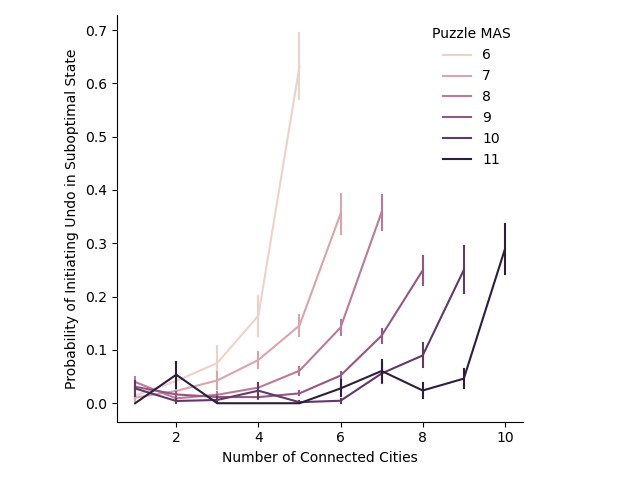

In [39]:
df_plot = undo_error.groupby(["subjects","allMAS","currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["allMAS","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["allMAS","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "allMAS", 
        #      color = "k",
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Suboptimal State')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_error_step.png', dpi=300, bbox_inches='tight')

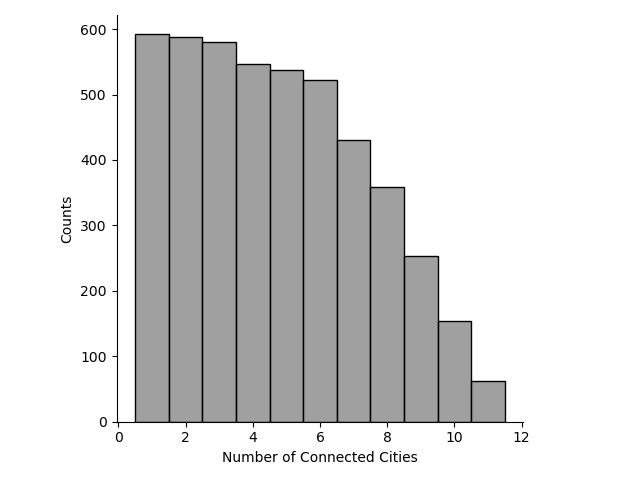

In [70]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.histplot(x = 'currNumCities',
            #  hue = 'allMAS', 
            #  multiple="layer", 
            #  element = "poly", 
            #  fill = False, 
             color = "grey",
             discrete=True, 
             data = df_plot
             )
axs.set(xlabel='Number of Connected Cities',
        ylabel='Counts')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'currNumCity_dist.png', dpi=300, bbox_inches='tight')

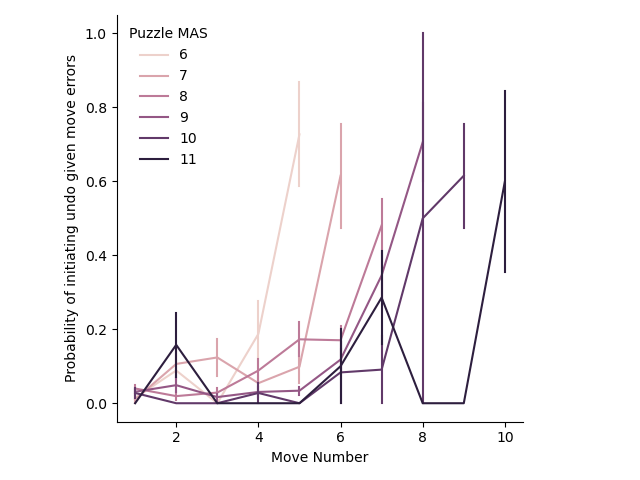

In [35]:
df_plot = move_undo_error.groupby(["subjects","allMAS", "currNumCities"])['undo'].mean().reset_index()
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', hue = "allMAS", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Move Number', 
        ylabel='Probability of initiating undo given move errors')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
# fig.savefig(out_dir+'undo_error_step.png', dpi=300, bbox_inches='tight')

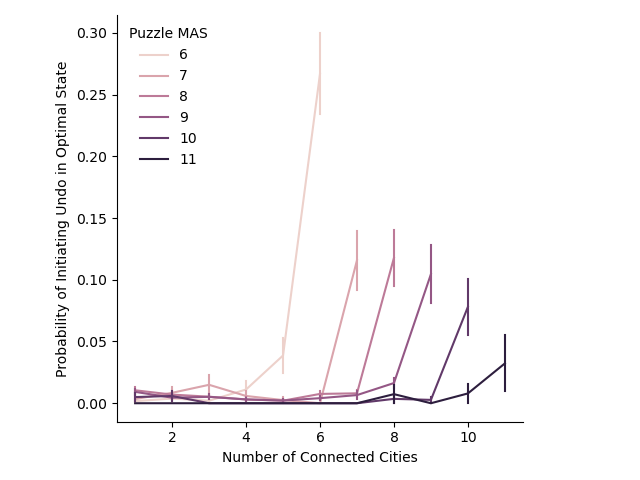

In [40]:
df_plot = undo_noerror.groupby(["subjects","allMAS", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["allMAS","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["allMAS","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "allMAS", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

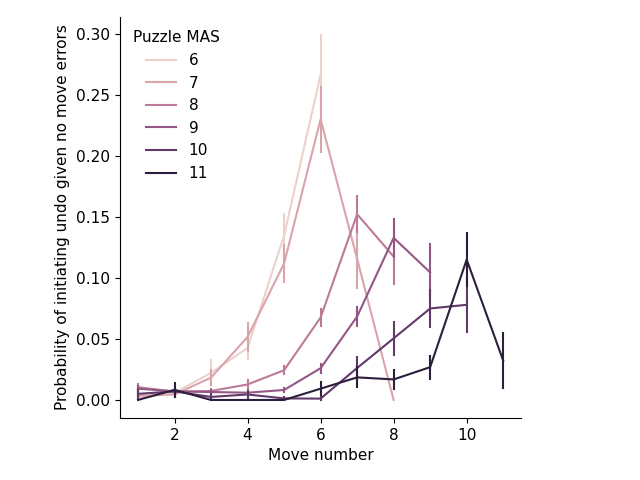

In [284]:
df_plot = move_undo_noerror.groupby(["subjects","allMAS", "currNumCities"])['undo'].mean().reset_index()
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', hue = "allMAS", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Move number', 
        ylabel='Probability of initiating undo given no move errors')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
# fig.savefig(out_dir+'undo_step.png', dpi=300, bbox_inches='tight')

### Hit/false alarm across puzzle MAS

In [285]:
undo_noerror_puzzle_avg = undo_noerror.groupby(["subjects", "allMAS"])['undo'].mean().reset_index()
# print(undo_noerror_puzzle_avg.groupby(["allMAS"]).count())

undo_error_puzzle_avg = undo_error.groupby(["subjects", "allMAS"])['undo'].mean().reset_index()
# print(undo_error_puzzle_avg.groupby(["allMAS"]).count())

# caculcate balanced accuracy 
undo_noerror_puzzle_avg['TNR'] = 1 - undo_noerror_puzzle_avg['undo'] # True Negative Rate
# Initialize 'TNR' column with NaN instead of None
undo_error_puzzle_avg['TNR'] = np.nan
# Merge the TNR values from undo_noerror_puzzle_avg to undo_error_puzzle_avg based on 'subjects' and 'allMAS'
undo_error_puzzle_avg = undo_error_puzzle_avg.merge(undo_noerror_puzzle_avg[['subjects', 'allMAS', 'TNR']], on=['subjects', 'allMAS'], how='left', suffixes=('', '_noerror'))
# Fill the 'TNR' column in undo_error_puzzle_avg with the values from undo_noerror_puzzle_avg where they match
undo_error_puzzle_avg['TNR'] = undo_error_puzzle_avg['TNR'].fillna(undo_error_puzzle_avg['TNR_noerror'])
# Drop the extra TNR column
undo_error_puzzle_avg.drop(columns=['TNR_noerror'], inplace=True)
# Calculate balanced accuracy
undo_error_puzzle_avg['balanced_accuracy'] = (undo_error_puzzle_avg['undo'] + undo_error_puzzle_avg['TNR']) / 2

# Print or return the result
print(undo_error_puzzle_avg)

     subjects  allMAS      undo       TNR  balanced_accuracy
0           0       7  0.000000  0.923077           0.461538
1           0       8  0.089286  1.000000           0.544643
2           0       9  0.065574  0.990196           0.527885
3           0      11  0.000000  1.000000           0.500000
4           1       7  0.200000  1.000000           0.600000
..        ...     ...       ...       ...                ...
548        99       7  0.185185  1.000000           0.592593
549        99       8  0.114583  0.990385           0.552484
550        99       9  0.064935  1.000000           0.532468
551        99      10  0.000000  1.000000           0.500000
552        99      11  0.000000  1.000000           0.500000

[553 rows x 5 columns]


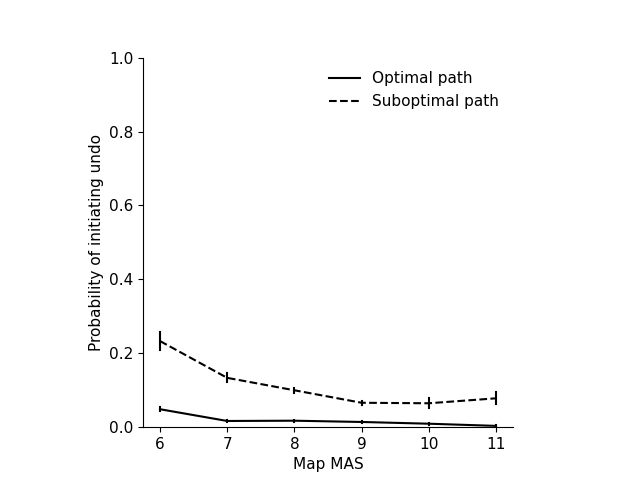

In [286]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='undo', 
             data = undo_noerror_puzzle_avg,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='allMAS', y='undo',
                data = undo_error_puzzle_avg,
                color = 'k',
                err_style = "bars",
                errorbar = "se",
                linestyle = "--")
# sns.lineplot(x='allMAS', y='balanced_accuracy',
#                 data = undo_error_puzzle_avg,
#                 color = 'k',
#                 err_style = "bars",
#                 errorbar = "se",
#                 linestyle = "-.")
# add legend
axs.legend(['Optimal path', 'Suboptimal path'], frameon=False)

axs.set_ylim(0,1)
axs.set(xlabel='Map MAS', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'hit_falsealarm_mas.png', dpi=300, bbox_inches='tight')
plt.show()

### balanced accuracy and correlation

In [287]:
# count number of appearances
# condition negative
print(len(index_noerror))
# condition positive
print(len(index_error))

42780
4450


In [288]:
TNR = 1 - undo_noerror_avg # True Negative Rate 
balanced_accuracy = (undo_error_avg + TNR)/2

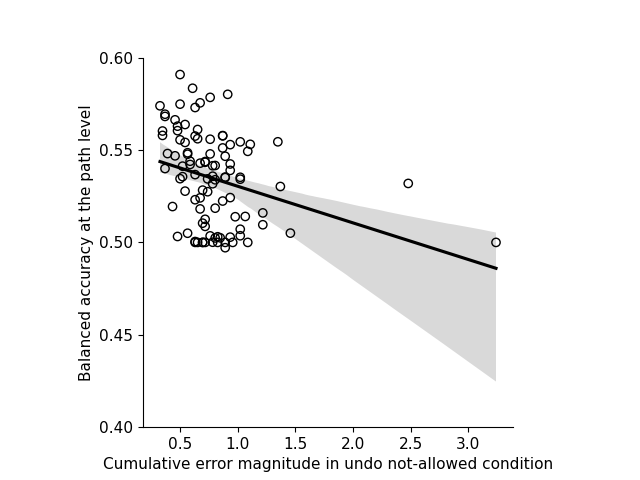

In [289]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy,               
             edgecolor="black",
                facecolor="None")
# add regplot line
sns.regplot(x=score, y=balanced_accuracy, ax=axs, ci=95, scatter=False, color='black')

# set yticks
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy at the path level') #Difference in undo initiation probability \nbetween optimal and suboptimal paths

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'path_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [290]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy)

SpearmanrResult(correlation=-0.38182817993772894, pvalue=8.85945768963304e-05)

### balanced accuracy and correlation (supp)

In [291]:
# count number of appearances
# condition negative
print(len(index_noerror))
# condition positive
print(len(index_error))

42780
4450


In [292]:
move_TNR = 1 - move_undo_noerror_avg # True Negative Rate 
balanced_accuracy_move = (move_undo_error_avg + move_TNR)/2

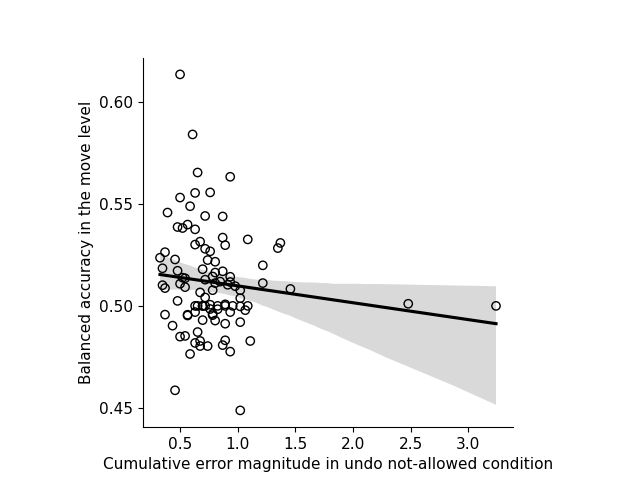

In [293]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy_move,               
             edgecolor="black",
                facecolor="None")
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

# add regplot line
sns.regplot(x=score, y=balanced_accuracy_move, ax=axs, ci=95, scatter=False, color='black')

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy in the move level') # Difference in undo initiation probability \nbetween optimal and suboptimal moves

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'move_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [294]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy_move)

SpearmanrResult(correlation=-0.13378809589916837, pvalue=0.18449713269822837)

### Two balanced accuracy comparison

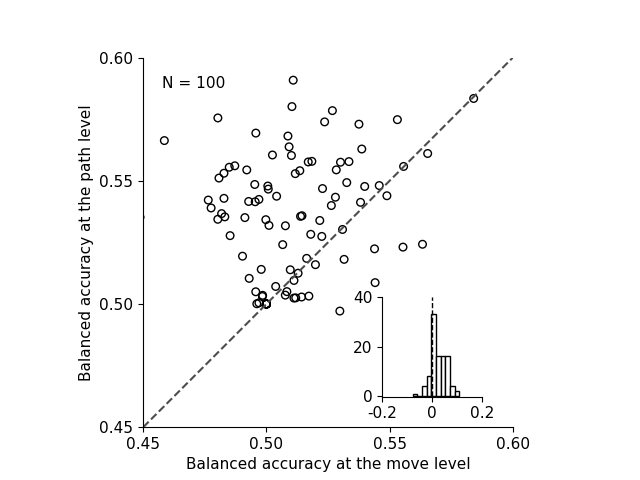

In [295]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(balanced_accuracy_move), 
            np.array(balanced_accuracy), 
            # use white fill
            facecolors = 'none',
            edgecolors='k',
            # size
            s = 30)

axs.set_xlabel('Balanced accuracy at the move level')
axs.set_ylabel('Balanced accuracy at the path level')

axis_range = [0.45,0.6]
axs.set_ylim(axis_range)
axs.set_xlim(axis_range)

# change number of x and y ticks
axs.set_xticks([0.45,0.5,0.55,0.6])
axs.set_yticks([0.45,0.5,0.55,0.6])

# add diagonal line
axs.plot(axis_range, axis_range, ls="--", c=".3")

# add text on upper left corner of the plot
axs.text(0.05, 0.95, "N = 100", transform=axs.transAxes,
        fontsize=11,  va='top')

# make inset ----
axins = inset_axes(plt.gca(), width="27%", height="27%", loc="lower right", borderpad=2)
axins.hist(np.array(balanced_accuracy) - np.array(balanced_accuracy_move), 
           bins=10, color='w', alpha=1, label='With undo', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,40], 'k--', linewidth=1)
# set x and y lim of axins
axins.set_xlim([-0.2,0.2])
axins.set_ylim([-0.2,0.2])
# set x and y ticks of axins
axins.set_xticks([-0.2,0,0.2])
axins.set_xticklabels(['-0.2','0','0.2'])
axins.set_yticks([0,20,40])

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'two_balanced_acc.png', dpi=300, bbox_inches='tight')

0.02473571685811436
0.025080358734526454


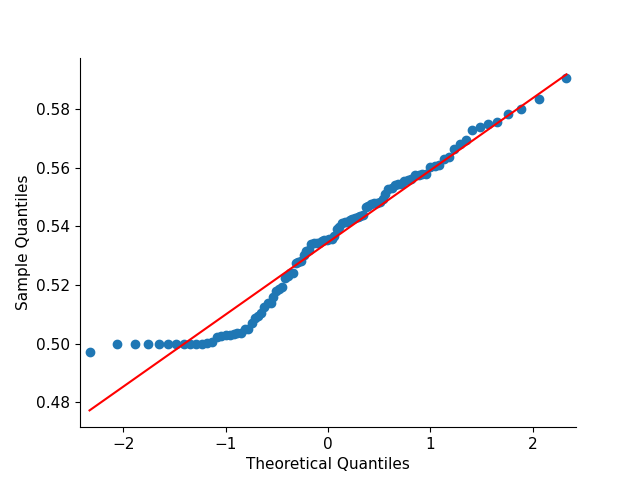

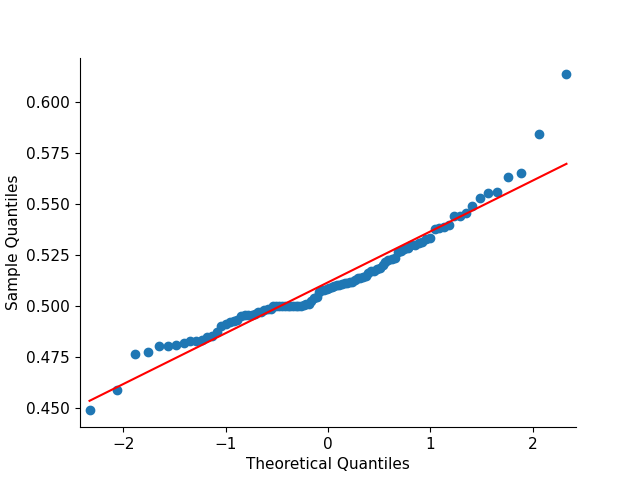

In [296]:
# run 2-independent-sample t test
## check variance
print(np.std(balanced_accuracy, ddof=1))
print(np.std(balanced_accuracy_move, ddof=1))
## check normality
sm.qqplot(balanced_accuracy, line='s')
py.show()
sm.qqplot(balanced_accuracy_move, line='s')
py.show()

In [297]:
stat1, p1 = wilcoxon(balanced_accuracy_move, balanced_accuracy)
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 1.3\\times 10^{-9}$')

## Error correction efficiency

### Make errors at the beginning

In [16]:
# remove the steps where the current connected cities is 1. Because the error is calculated as the current state feature. And when at the starting city, there cannot be errors commited.
# basic condition
data_cond0_outcome = data_choice_level[(data_choice_level['condition']==0)&(data_choice_level['currNumCities']!=0)&(data_choice_level['submit']!=1)]
# get the dataframe of the previous state
data_cond0_state = data_choice_level.iloc[data_cond0_outcome.index - 1,:].reset_index(drop=True)
data_cond0_outcome = data_cond0_outcome.reset_index(drop=True)
data_cond0_outcome['prevNumCities'] = data_cond0_state['currNumCities']

In [17]:
data_cond1_outcome = data_subset_before1undo[(data_subset_before1undo['currNumCities']!=0)&(data_subset_before1undo['submit']!=1)]
# get the dataframe of the previous state
data_cond1_state = sc_data_choice_level.iloc[data_cond1_outcome.index - 1,:].reset_index(drop=True)
data_cond1_outcome = data_cond1_outcome.reset_index(drop=True)
data_cond1_outcome['prevNumCities'] = data_cond1_state['currNumCities']

In [18]:
data_cond1_undo_outcome = data_subset_before1undoonly[(data_subset_before1undoonly['currNumCities']!=0)&(data_subset_before1undoonly['submit']!=1)]
# get the dataframe of the previous state
data_cond1_undo_state = sc_data_choice_level.iloc[data_cond1_undo_outcome.index - 1,:].reset_index(drop=True)
data_cond1_undo_outcome = data_cond1_undo_outcome.reset_index(drop=True)
data_cond1_undo_outcome['prevNumCities'] = data_cond1_undo_state['currNumCities']

#### Basic condition (supp)

In [21]:
error_sub = data_cond0_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

prevNumCities  allMAS  error
0               0       8    100
1               0       9    100
2               1       8    100
3               1       9    100
4               2       8    100
5               2       9    100
6               3       8    100
7               3       9    100
8               4       8    100
9               4       9    100
10              5       8    100
11              5       9    100
12              6       8     98
13              6       9     99
14              7       8     94
15              7       9     97
16              8       9     93

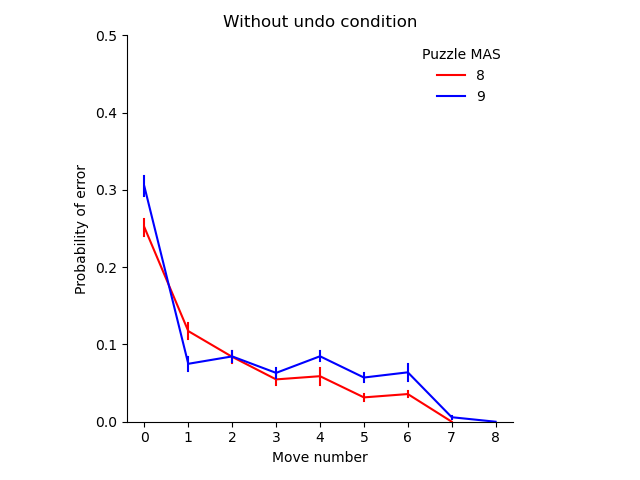

In [22]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Without undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_basic_condition.png', dpi=300, bbox_inches='tight')

In [303]:
%%R -i data_cond0_outcome,out_dir2
data_cond0_outcome$subjects <- as.factor(data_cond0_outcome[,"subjects"])
data_cond0_outcome$allMAS <- as.factor(data_cond0_outcome[,"allMAS"])

model_error = lme4::glmer(error ~  1 + prevNumCities + allMAS + (1 |subjects),
                                  data = data_cond0_outcome[(data_cond0_outcome$allMAS==8)|(data_cond0_outcome$allMAS==9),], family = "binomial")

save(model_error, data_cond0_outcome, file=file.path(out_dir2, file=paste("model_error_step_basic_condition.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond0_outcome[(data_cond0_outcome$allMAS == 8) | (data_cond0_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14572.4  14605.3  -7282.2  14564.4    27387 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0427 -0.3540 -0.2325 -0.1478  8.7125 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1166   0.3415  
Number of obs: 27391, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.42462    0.05214  -27.32  < 2e-16 ***
prevNumCities -0.40420    0.01198  -33.73  < 2e-16 ***
allMAS9        0.16285    0.04450    3.66 0.000252 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

#### Undo condition

In [124]:
error_sub = data_subset_before1undo.groupby(['subjects','currNumCities',"allMAS"])['cumulative_error'].mean().reset_index()
count_df = error_sub.groupby(["currNumCities","allMAS"])['cumulative_error'].count().reset_index()
# filter df_plot if count_df > 10
error_sub = error_sub.merge(count_df, on = ["currNumCities","allMAS"], how = "left", suffixes = ("","_count"))
error_sub = error_sub[error_sub['cumulative_error_count'] > 30]
count_df

currNumCities  allMAS  cumulative_error
0               0       6               100
1               0       7               100
2               0       8               100
3               0       9               100
4               0      10               100
5               0      11               100
6               1       6               100
7               1       7               100
8               1       8               100
9               1       9               100
10              1      10               100
11              1      11               100
12              2       6               100
13              2       7               100
14              2       8               100
15              2       9               100
16              2      10               100
17              2      11               100
18              3       6               100
19              3       7               100
20              3       8               100
21              3       9               100
22              3      10               100
23              3      11               100
24              4       6                99
25              4       7               100
26              4       8               100
27              4       9               100
28              4      10               100
29              4      11               100
30              5       6                99
31              5       7               100
32              5       8               100
33              5       9               100
34              5      10               100
35              5      11               100
36              6       6                81
37              6       7                95
38              6       8               100
39              6       9               100
40              6      10               100
41              6      11               100
42              7       7                59
43              7       8                99
44              7       9               100
45              7      10                99
46              7      11               100
47              8       8                98
48              8       9               100
49              8      10                99
50              8      11                97
51              9       9                98
52              9      10                97
53              9      11                91
54             10      10                85
55             10      11                86
56             11      11                48

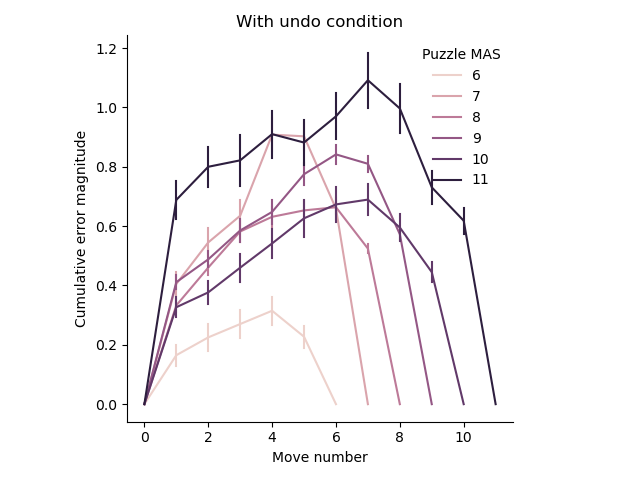

In [24]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='cumulative_error', hue = "allMAS", 
             data = error_sub, # .loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:]
             errorbar = "se",
             err_style = "bars",
            #  palette = ['red','blue']
             )
axs.set(xlabel='Move number', ylabel='Cumulative error magnitude')
# axs.set_ylim(0,0.5)
# axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'cumulative_error_step_undo_condition.png', dpi=300, bbox_inches='tight')

In [25]:
error_sub = data_cond1_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()
count_df = error_sub.groupby(["prevNumCities","allMAS"])['error'].count().reset_index()
# filter df_plot if count_df > 10
error_sub = error_sub.merge(count_df, on = ["prevNumCities","allMAS"], how = "left", suffixes = ("","_count"))
error_sub = error_sub[error_sub['error_count'] > 30]

In [26]:
puzzleCount = data_cond1_outcome.loc[(data_cond1_outcome.allMAS==9)&(data_cond1_outcome.prevNumCities==4),:].groupby(['puzzleID'])["error"].mean().reset_index()
print(np.mean(puzzleCount.error))
print(np.std(puzzleCount.error))

0.11001802409003511
0.13734618457502284


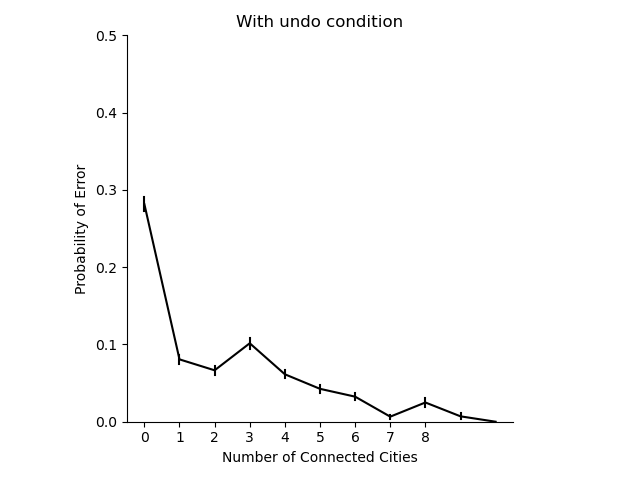

In [30]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, # .loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:]
             errorbar = "se",
             err_style = "bars",
            #  palette = ['red','blue']
             )
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of Error')
axs.set_ylim(0,0.5)
axs.set_xticks([0,1,2,3,4,5,6,7,8])
# axs.legend(title = "Puzzle MAS", frameon=False)
axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_undo_condition.png', dpi=300, bbox_inches='tight')

In [307]:
%%R -i data_cond1_outcome,out_dir2
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$allMAS <- as.factor(data_cond1_outcome[,"allMAS"])

model_error = lme4::glmer(error ~  1 + prevNumCities + allMAS + (1 |subjects),
                                  data = data_cond1_outcome[(data_cond1_outcome$allMAS==8)|(data_cond1_outcome$allMAS==9),], family = "binomial")

save(model_error, data_cond1_outcome, file=file.path(out_dir2, file=paste("model_error_step_undo_condition.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond1_outcome[(data_cond1_outcome$allMAS == 8) | (data_cond1_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14505.5  14538.4  -7248.7  14497.5    27594 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0280 -0.3537 -0.2240 -0.1363  9.4356 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.07439  0.2728  
Number of obs: 27598, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.36711    0.04774 -28.637  < 2e-16 ***
prevNumCities -0.43738    0.01208 -36.206  < 2e-16 ***
allMAS9        0.22579    0.04450   5.074  3.9e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

#### Given undo (supp)

In [308]:
error_sub = data_cond1_undo_outcome.groupby(['subjects','prevNumCities',"allMAS"])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:].groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

prevNumCities  allMAS  error
0               0       8     85
1               0       9     82
2               1       8     84
3               1       9     81
4               2       8     82
5               2       9     77
6               3       8     82
7               3       9     76
8               4       8     79
9               4       9     75
10              5       8     77
11              5       9     75
12              6       8     69
13              6       9     73
14              7       8     40
15              7       9     66
16              8       9     36

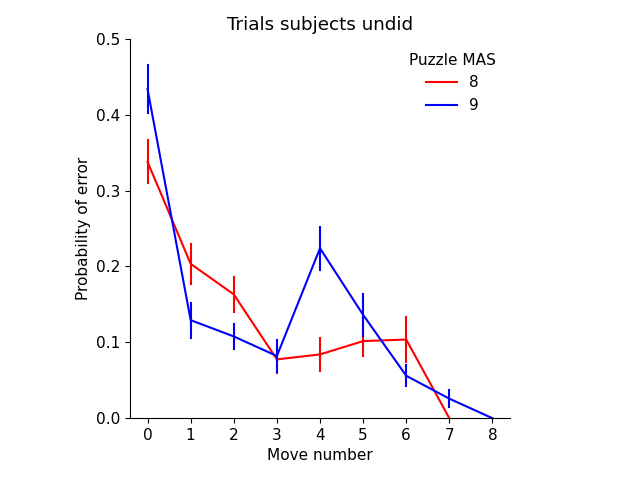

In [309]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='prevNumCities', y='error', hue = "allMAS", 
             data = error_sub.loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars",
             palette = ['red','blue'])
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Trials subjects undid")
# set x_ticks
axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_given_undo.png', dpi=300, bbox_inches='tight')


In [310]:
%%R -i data_cond1_undo_outcome,out_dir2
data_cond1_undo_outcome$subjects <- as.factor(data_cond1_undo_outcome[,"subjects"])
data_cond1_undo_outcome$allMAS <- as.factor(data_cond1_undo_outcome[,"allMAS"])

model_error = lme4::glmer(error ~  1 + prevNumCities + allMAS + (1 |subjects),
                                  data = data_cond1_undo_outcome[(data_cond1_undo_outcome$allMAS==8)|(data_cond1_undo_outcome$allMAS==9),], family = "binomial")

save(model_error, data_cond1_undo_outcome, file=file.path(out_dir2, file=paste("model_error_step_given_undo.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: data_cond1_undo_outcome[(data_cond1_undo_outcome$allMAS == 8) |  
    (data_cond1_undo_outcome$allMAS == 9), ]

     AIC      BIC   logLik deviance df.resid 
  5200.1   5227.5  -2596.0   5192.1     6910 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7150 -0.4614 -0.3223 -0.2194  5.0797 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.0318   0.1783  
Number of obs: 6914, groups:  subjects, 88

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.04166    0.06631 -15.709  < 2e-16 ***
prevNumCities -0.34095    0.01910 -17.855  < 2e-16 ***
allMAS9        0.20405    0.07212   2.829  0.00466 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
p

### Undo at the end

#### Across step

In [149]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_bf_1undo = data_subset_before1undo.index[(data_subset_before1undo.submit!=1)&(data_subset_before1undo.currNumCities!=0)]

state_df_1undo = data_subset_before1undo.loc[index_bf_1undo, ["subjects", "allMAS", "currNumCities", "checkEnd", "cumulative_error","currMas"]]
state_df_1undo = state_df_1undo.reset_index(drop=True)
state_df_1undo["firstUndo"] = list(sc_data_choice_level.loc[index_bf_1undo+1, "firstUndo"])
state_df_1undo["N_more"] = state_df_1undo["currMas"] - state_df_1undo["currNumCities"]
state_df_1undo

subjects  allMAS  currNumCities  checkEnd  cumulative_error  currMas  \
0             0       8              1         0                 0        8   
1             0       8              2         0                 0        8   
2             0       8              3         0                 0        8   
3             0       8              4         0                 0        8   
4             0       8              5         0                 0        8   
...         ...     ...            ...       ...               ...      ...   
35341        99       9              5         0                 0        9   
35342        99       9              6         0                 0        9   
35343        99       9              7         0                 0        9   
35344        99       9              8         0                 0        9   
35345        99       9              9         1                 0        9   

       firstUndo  N_more  
0              0       7  
1              0       6  
2              0       5  
3              0       4  
4              0       3  
...          ...     ...  
35341          0       4  
35342          0       3  
35343          0       2  
35344          0       1  
35345          0       0  

[35346 rows x 8 columns]

In [150]:
firstUndo_sub = state_df_1undo.groupby(['subjects','N_more', "allMAS"])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(["N_more","allMAS"])['firstUndo'].count().reset_index()
# filter df_plot if count_df > 10
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["N_more","allMAS"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

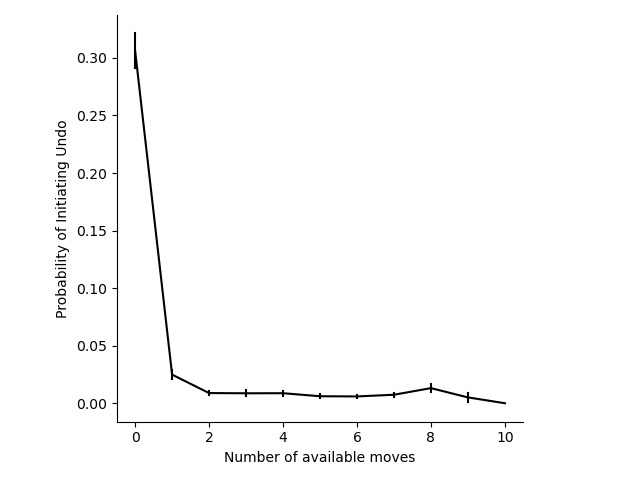

In [151]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='N_more', y='firstUndo', 
        #      hue = "allMAS", 
             color = 'k',
             data = firstUndo_sub,#.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars"
             #palette = ['red','blue']
             )
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of available moves', 
        ylabel='Probability of Initiating Undo')
# set legend title
# axs.legend(title = "Puzzle MAS", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_nmore.png', dpi=300, bbox_inches='tight')

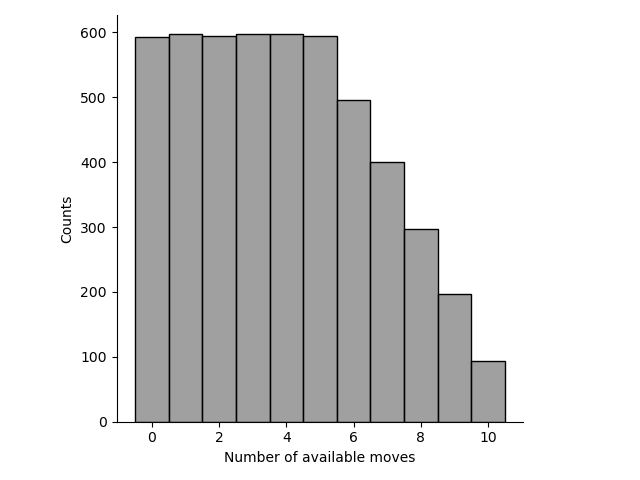

In [152]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.histplot(x = 'N_more',
            #  hue = 'allMAS', 
            #  multiple="layer", 
            #  element = "poly", 
            #  fill = False, 
             color = "grey",
             discrete=True, 
             data = firstUndo_sub
             )
axs.set(xlabel='Number of available moves',
        ylabel='Counts')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'Nmore_dist.png', dpi=300, bbox_inches='tight')

In [61]:
firstUndo_sub = state_df_1undo.groupby(['subjects','currNumCities',"allMAS"])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(["currNumCities","allMAS"])['firstUndo'].count().reset_index()
# filter df_plot if count_df > 10
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["currNumCities","allMAS"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

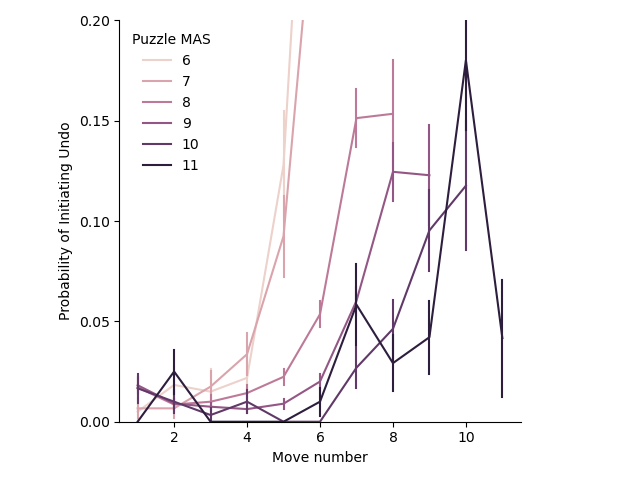

In [62]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', hue = "allMAS", 
             data = firstUndo_sub,#.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars"
             #palette = ['red','blue']
             )
axs.set_yticks(np.linspace(0,0.2,5))
axs.set_ylim([0,0.2])
axs.set(xlabel='Move number', 
        ylabel='Probability of Initiating Undo')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_step.png', dpi=300, bbox_inches='tight')

In [153]:
%%R -i state_df_1undo,out_dir2
# state_df_1undo$subjects <- toString(state_df_1undo[,"subjects"])
state_df_1undo$checkEnd <- as.factor(state_df_1undo[,"checkEnd"])

model_undo = glm(firstUndo ~  1 + currNumCities + allMAS + checkEnd + (1 |subjects),
                                  data = state_df_1undo, family = binomial())
model_undo2 = glm(firstUndo ~  1 + currNumCities + allMAS + (1 |subjects),
                                data = state_df_1undo, family = binomial())

save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_step.RData", sep="")))
save(model_undo2, state_df_1undo, file=file.path(out_dir2, file=paste("model2_undo_step.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)


Call:
glm(formula = firstUndo ~ 1 + currNumCities + allMAS + checkEnd + 
    (1 | subjects), family = binomial(), data = state_df_1undo)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1613  -0.1735  -0.1419  -0.1159   3.5006  

Coefficients: (1 not defined because of singularities)
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.94421    0.26697 -11.028  < 2e-16 ***
currNumCities    -0.20277    0.02279  -8.896  < 2e-16 ***
allMAS           -0.10482    0.03393  -3.089  0.00201 ** 
checkEnd1         4.34605    0.12063  36.029  < 2e-16 ***
1 | subjectsTRUE       NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11911.4  on 35345  degrees of freedom
Residual deviance:  8232.1  on 35342  degrees of freedom
AIC: 8240.1

Number of Fisher Scoring iterations: 7



In [ ]:
%%R
compareGLM(model_undo, model_undo2)

#### Terminal is special?

In [17]:
terminal_idx = state_df_1undo[state_df_1undo.checkEnd==1].index 
error_1before_terminal = state_df_1undo.loc[terminal_idx-1, ["subjects", "cumulative_error"]].reset_index(drop=True).groupby(["subjects"])['cumulative_error'].mean().reset_index()
error_at_terminal = state_df_1undo.loc[terminal_idx, ["subjects", "cumulative_error"]].reset_index(drop=True).groupby(["subjects"])['cumulative_error'].mean().reset_index()

wilcoxon(error_1before_terminal.cumulative_error, error_at_terminal.cumulative_error)


WilcoxonResult(statistic=0.0, pvalue=7.747005972078271e-15)

#### Terminal or not

##### Proportion of undo

In [50]:
all_undo = (data_choice_level.firstUndo == 1)
end_undo = data_choice_level.loc[data_choice_level.loc[all_undo,:].index-1, ["checkEnd",'subjects','puzzleID','allMAS']]

endUndo_sub = end_undo.groupby(['subjects'])['checkEnd'].mean().reset_index()

endUndo_sub

subjects  checkEnd
0          0  0.909091
1          1  0.608696
2          2  0.888889
3          3  1.000000
4          4  0.904762
..       ...       ...
85        94  1.000000
86        95  0.939394
87        96  0.905660
88        97  0.000000
89        99  0.923077

[90 rows x 2 columns]

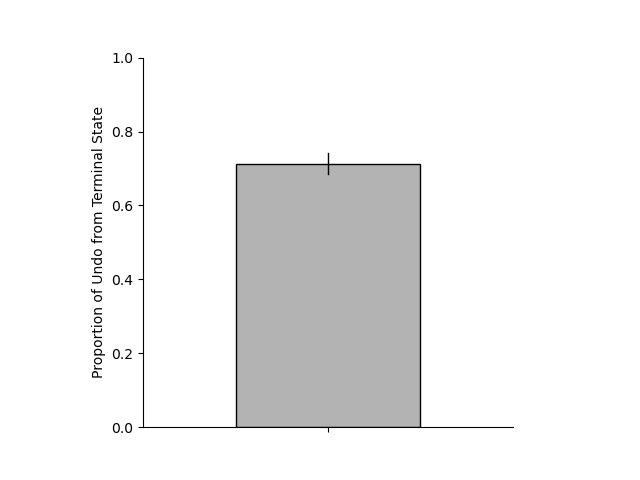

In [53]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(y='checkEnd', 
            data = endUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of Undo from Terminal State')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig(out_dir+'undo_terminal.png', dpi=300, bbox_inches='tight')

##### Probability of undo

In [41]:
# state_df_1undo_sub = state_df_1undo[(state_df_1undo.allMAS==8)|(state_df_1undo.allMAS==9)]
undo_end_sub = state_df_1undo[state_df_1undo.checkEnd==1].groupby(['subjects'])['firstUndo'].mean()
undo_notend_sub = state_df_1undo[state_df_1undo.checkEnd==0].groupby(['subjects'])['firstUndo'].mean()
print(len(undo_end_sub))
print(undo_notend_sub)

# # count number of undos in state_df_1undo[state_df_1undo.checkEnd==1]
# n1 = len(state_df_1undo[(state_df_1undo.checkEnd==1)&(state_df_1undo.firstUndo==1)])
# n2 = len(state_df_1undo[(state_df_1undo.checkEnd==0)&(state_df_1undo.firstUndo==1)])
# print(n1)
# print(n2)
# n1/(n1+n2)

100
subjects
0     0.003195
1     0.025316
2     0.006135
3     0.000000
4     0.003226
        ...   
95    0.006098
96    0.008824
97    0.010033
98    0.000000
99    0.006309
Name: firstUndo, Length: 100, dtype: float64


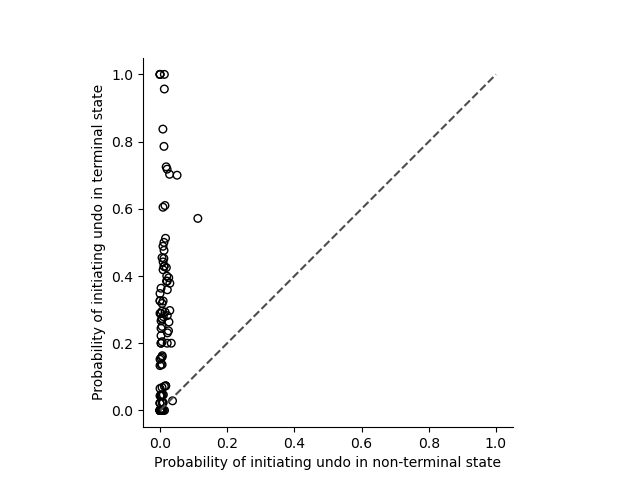

In [42]:
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

axs.scatter(np.array(undo_notend_sub), 
            np.array(undo_end_sub), 
            facecolors = 'none',  # use white fill
            edgecolors='k',
            s = 30 # size
            )

axs.set_xlabel('Probability of initiating undo in non-terminal state')
axs.set_ylabel('Probability of initiating undo in terminal state')

axs.set_ylim([-0.05,1.05])
axs.set_xlim([-0.05,1.05])

axs.plot([0,1], [0,1], ls="--", c=".3") # add diagonal line
axs.set_aspect(1/axs.get_data_ratio()) # set ratio to be 1:1
plt.show()

fig.savefig(out_dir+'undo_terminal.png', dpi=300, bbox_inches='tight')

0.2669240927236181
0.015217854631966633


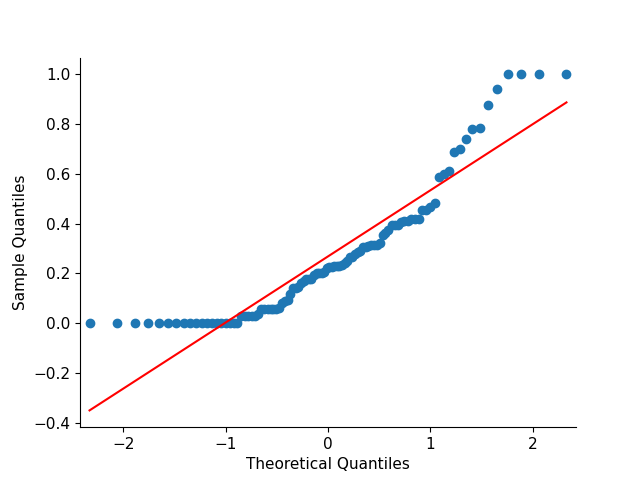

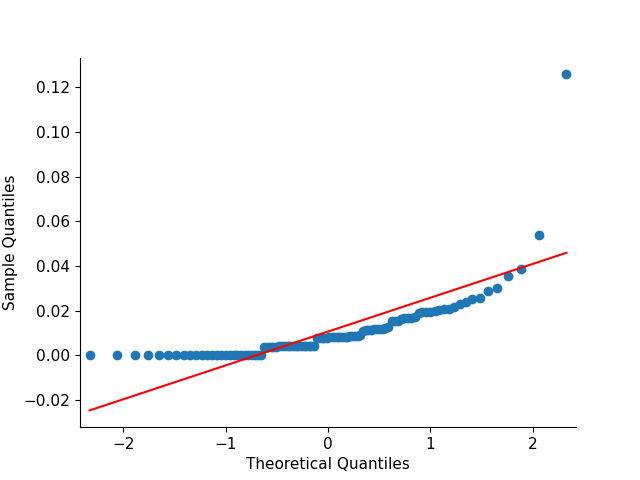

Text(0.5, 1.0, '$p = 4.5\\times 10^{-16}$')

In [317]:
# check equal variance ----
print(np.std(undo_end_sub, ddof=1))
print(np.std(undo_notend_sub, ddof=1))
## violated

# check normality ----
sm.qqplot(undo_end_sub, line='s')
py.show()
sm.qqplot(undo_notend_sub, line='s')
py.show()
## violated

stat1, p1 = mannwhitneyu(np.array(undo_end_sub), np.array(undo_notend_sub)) # should not be paired test! Because of unequal variance, and the measurements are rather unrelated
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

### Sequential undo - terminal

In [46]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
end_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["checkEnd",'subjects','puzzleID','allMAS']]
# end_singleundo = end_singleundo.loc[(end_singleundo.allMAS==8)|(end_singleundo.allMAS==9),:]
end_singleundo['singleUndo'] = 1
end_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)
end_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["checkEnd",'subjects','puzzleID','allMAS']]
# end_sequentialundo = end_sequentialundo.loc[(end_sequentialundo.allMAS==8)|(end_sequentialundo.allMAS==9),:]
end_sequentialundo['singleUndo'] = 0
end_sequentialundo['sequentialUndo'] = 1

end_undo_df = pd.concat([end_singleundo,end_sequentialundo])

# end_singleundo_avg = end_singleundo.groupby(['subjects'])['checkEnd'].mean()
# end_sequentialundo_avg = end_sequentialundo.groupby(['subjects'])['checkEnd'].mean()

print(sum(end_undo_df.checkEnd==1))
print(sum(end_undo_df.checkEnd==0))
print(sum(end_undo_df.checkEnd==1)+sum(end_undo_df.checkEnd==0))

2094
566
2660


In [47]:
sequentialUndo_sub = end_undo_df.groupby(['subjects','checkEnd'])['sequentialUndo'].mean().reset_index()

n_sub = sequentialUndo_sub.groupby(['checkEnd'])['sequentialUndo'].count().reset_index()
print(n_sub)

   checkEnd  sequentialUndo
0         0              79
1         1              84


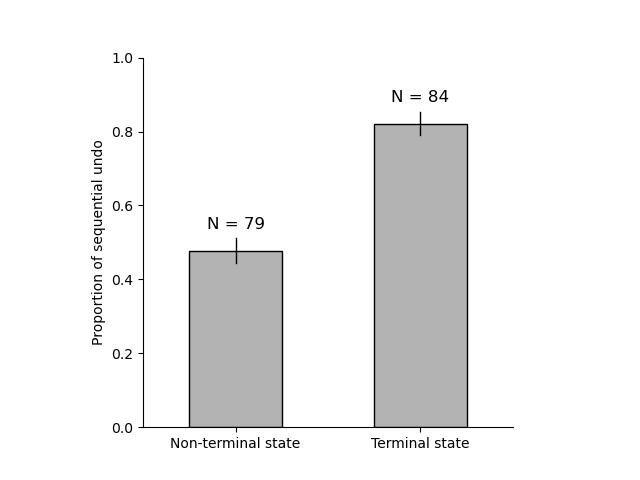

In [48]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(x='checkEnd', y='sequentialUndo', 
            data = sequentialUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_xticklabels(labels = [ "Non-terminal state" , "Terminal state"])#,fontsize=18

# add text on the upper of each bar 
for x, y, n in zip([0,1], sequentialUndo_sub.groupby(['checkEnd'])['sequentialUndo'].mean(), n_sub.sequentialUndo):
    axs.text(x, y+0.05, "N = " + str(n), ha='center', va='bottom', fontsize=12)

axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of sequential undo')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig(out_dir+'sequential_terminal.png', dpi=300, bbox_inches='tight')

0.27298251456348316
0.31915638979557404


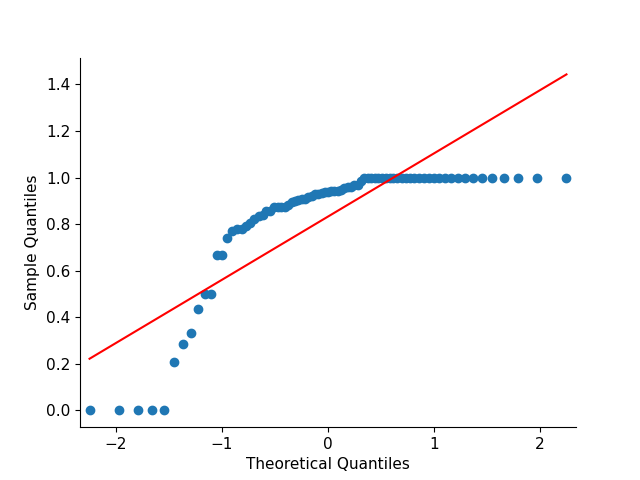

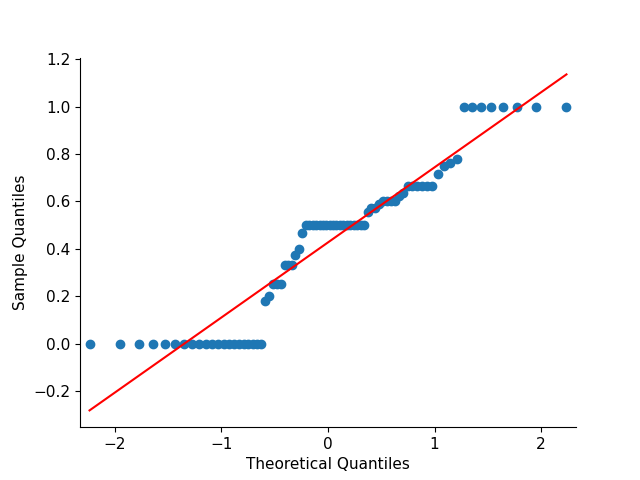

In [321]:
# run 2-independent-sample t test
## check variance
print(np.std(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo'], ddof=1))
print(np.std(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'], ddof=1))
## check normality
sm.qqplot(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo'], line='s')
py.show()
sm.qqplot(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'], line='s')
py.show()

In [322]:
stat1, p1 = mannwhitneyu(np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo']), 
                     np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'])) 
axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))

Text(0.5, 1.0, '$p = 4.1\\times 10^{-13}$')

### Sequential - error magnitude

#### Probability

In [175]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_undo = sc_data_choice_level.index[(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_undo+1, ["subjects","undo",'firstUndo','lastUndo']]
# add sc_data_choice_level.loc[index_undo, "severityOfErrors"] as a list column to undo_error
undo_error['severityOfErrors'] = sc_data_choice_level.loc[index_undo, "severityOfErrors"].values
undo_error['cumulative_error'] = sc_data_choice_level.loc[index_undo, "cumulative_error"].values
undo_error['missed_reward'] = sc_data_choice_level.loc[index_undo, "missed_reward"].values
undo_error['error_rate'] = sc_data_choice_level.loc[index_undo, "error_rate"].values
undo_error['checkEnd'] = sc_data_choice_level.loc[index_undo, "checkEnd"].values
undo_error['sequential_undo'] = (undo_error.firstUndo != undo_error.lastUndo)&(undo_error.firstUndo == 1)
undo_error['single_undo'] = (undo_error.firstUndo == undo_error.lastUndo)&(undo_error.firstUndo == 1)

In [184]:
allUndo_sub_end = undo_error[undo_error.checkEnd==1].groupby(['subjects','cumulative_error'])['undo'].mean().reset_index()
allUndo_sub_nonend = undo_error[undo_error.checkEnd==0].groupby(['subjects','cumulative_error'])['undo'].mean().reset_index()
print(allUndo_sub_end.groupby(['cumulative_error'])['subjects'].count().reset_index())
print(allUndo_sub_nonend.groupby(['cumulative_error'])['subjects'].count().reset_index())

   cumulative_error  subjects
0                 0        99
1                 1        99
2                 2       100
3                 3        79
4                 4        37
5                 5         7
6                 6         1
7                 8         1
   cumulative_error  subjects
0                 0       100
1                 1       100
2                 2       100
3                 3        78
4                 4        37
5                 5         7
6                 6         3


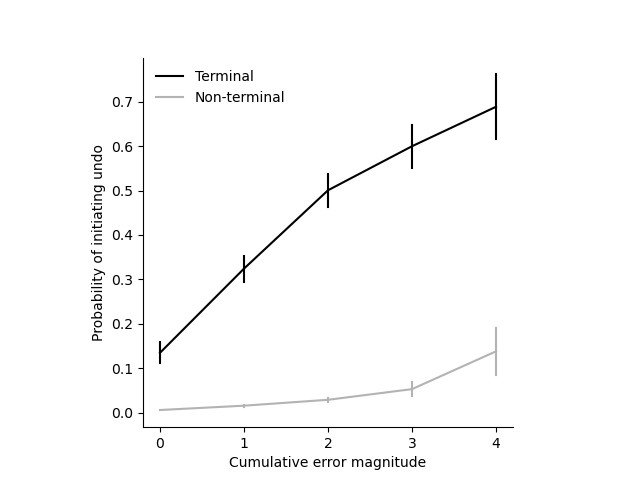

In [187]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='undo', 
             data = allUndo_sub_end[allUndo_sub_end.cumulative_error<5], 
             color = 'k',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='cumulative_error', y='undo',
             data = allUndo_sub_nonend[allUndo_sub_nonend.cumulative_error<5],
             color = [0.7,0.7,0.7],
             err_style = "bars",
             errorbar = "se")

# add manual legend
plt.legend(labels=['Terminal','Non-terminal'], loc='upper left')

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Cumulative error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'terminal_error_magnitude.png', dpi=300, bbox_inches='tight')

In [171]:
allUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['undo'].mean().reset_index()
singleUndo_sub = undo_error.groupby(['subjects','severityOfErrors'])['single_undo'].mean().reset_index()
sequentialundo_sub = undo_error.groupby(['subjects','severityOfErrors'])['sequential_undo'].mean().reset_index()
print(allUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index())
print(singleUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index())
print(sequentialundo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index())

   severityOfErrors  subjects
0                 0       100
1                 1       100
2                 2        98
3                 3        63
4                 4        22
5                 5         3
6                 6         2
   severityOfErrors  subjects
0                 0       100
1                 1       100
2                 2        98
3                 3        63
4                 4        22
5                 5         3
6                 6         2
   severityOfErrors  subjects
0                 0       100
1                 1       100
2                 2        98
3                 3        63
4                 4        22
5                 5         3
6                 6         2


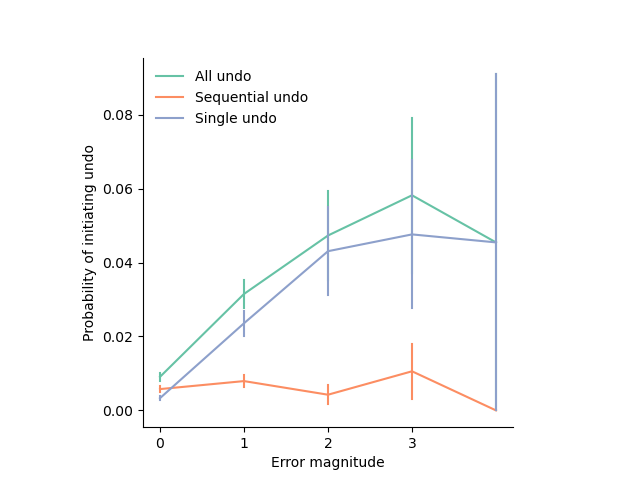

In [172]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='undo', 
             data = allUndo_sub[allUndo_sub.severityOfErrors<=4], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='sequential_undo',
             data = sequentialundo_sub[sequentialundo_sub.severityOfErrors<=4],
             color = '#fc8d62',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='single_undo',
                data = singleUndo_sub[singleUndo_sub.severityOfErrors<=4],
                color = '#8da0cb',
                err_style = "bars",
                errorbar = "se")

# add manual legend
plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_error_magnitude.png', dpi=300, bbox_inches='tight')

In [328]:
%%R -i undo_error,out_dir2
undo_error$subjects <- as.factor(undo_error[,"subjects"])

model_undo = lme4::glmer(undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error[(undo_error$severityOfErrors<=3),], family = "binomial")

save(model_undo, undo_error, file=file.path(out_dir2, file=paste("model_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error[(undo_error$severityOfErrors <= 3), ]

     AIC      BIC   logLik deviance df.resid 
 19227.6  19253.9  -9610.8  19221.6    47181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5989 -0.2826 -0.2286 -0.1184 13.0289 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.41     1.187   
Number of obs: 47184, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.51237    0.12662 -27.739  < 2e-16 ***
severityOfErrors  0.28037    0.04627   6.059 1.37e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.058


In [329]:
%%R -i undo_error,out_dir2
undo_error$subjects <- as.factor(undo_error[,"subjects"])

model_undo = lme4::glmer(sequential_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error[(undo_error$severityOfErrors<=3),], family = "binomial")

save(model_undo, undo_error, file=file.path(out_dir2, file=paste("model_sequential_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequential_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error[(undo_error$severityOfErrors <= 3), ]

     AIC      BIC   logLik deviance df.resid 
 16031.0  16057.3  -8012.5  16025.0    47181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.3743 -0.2494 -0.2018 -0.0950 14.2864 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.932    1.39    
Number of obs: 47184, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.90865    0.15101 -25.883  < 2e-16 ***
severityOfErrors -0.28306    0.07342  -3.855 0.000116 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.041


In [330]:
%%R -i undo_error,out_dir2
undo_error$subjects <- as.factor(undo_error[,"subjects"])

model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_error[(undo_error$severityOfErrors<=3),], family = "binomial")

save(model_undo, undo_error, file=file.path(out_dir2, file=paste("model_single_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: single_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_error[(undo_error$severityOfErrors <= 3), ]

     AIC      BIC   logLik deviance df.resid 
  5363.7   5390.0  -2678.8   5357.7    47181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6426 -0.0988 -0.0794 -0.0570 21.4739 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.199    1.095   
Number of obs: 47184, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.28211    0.13389  -39.45   <2e-16 ***
severityOfErrors  1.03828    0.05983   17.35   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.187


#### Proportion

In [331]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
error_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["severityOfErrors",'subjects','allMAS']]
error_singleundo['singleUndo'] = 1
error_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)
error_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["severityOfErrors",'subjects','allMAS']]
error_sequentialundo['singleUndo'] = 0
error_sequentialundo['sequentialUndo'] = 1

error_undo_df = pd.concat([error_singleundo,error_sequentialundo])

In [332]:
singleUndo_sub = error_undo_df.groupby(['subjects','severityOfErrors','allMAS'])['singleUndo'].mean().reset_index()
singleUndo_sub.groupby(['severityOfErrors','allMAS'])['subjects'].count().reset_index()

severityOfErrors  allMAS  subjects
0                  0       6        56
1                  0       7        64
2                  0       8        82
3                  0       9        78
4                  0      10        40
5                  0      11        39
6                  1       6        12
7                  1       7        20
8                  1       8        48
9                  1       9        56
10                 1      10        12
11                 1      11         7
12                 2       6         2
13                 2       7         7
14                 2       8        18
15                 2       9        11
16                 2      10         1
17                 2      11         1
18                 3       7         4
19                 3       8         4
20                 3       9         4
21                 3      11         3
22                 4       8         1
23                 4       9         1
24                 6       9         1

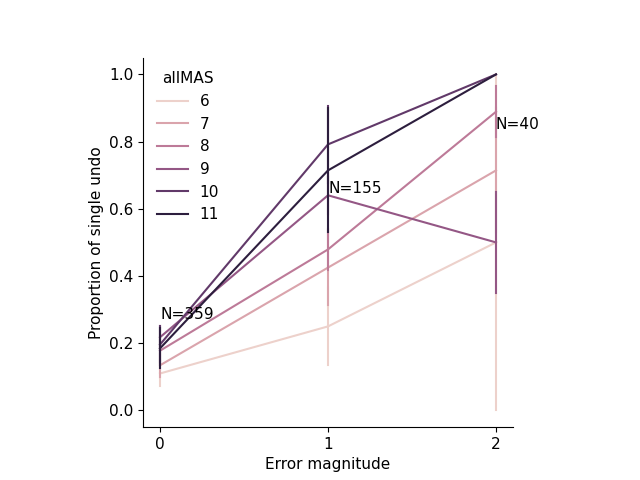

In [333]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
lineplot = sns.lineplot(x='severityOfErrors', y='singleUndo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=2], 
             hue = "allMAS",
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2])
axs.set_yticks([0,0.2,0.4,0.6,0.8,1])

n_sub = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['subjects'].count().reset_index()
# add each n_sub to each dot on the line,  y uses the position of each dot
# loop through lineplot dots
for i in range(len(n_sub)):
    # add text to lineplot
    lineplot.text(x = n_sub.severityOfErrors[i], # x-coordinate position of data label, padded to be right of the scatterplot
                  y = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['singleUndo'].mean()[i]+0.1, # y-coordinate position of data label, padded to be above scatterplot
                  s = "N="+str(n_sub.subjects[i]), # data label, formatted to ignore decimals
                  color = 'black') # set colour of line


#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Proportion of single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'prop_single_error_magnitude.png', dpi=300, bbox_inches='tight')

In [334]:
%%R -i error_undo_df,out_dir2
error_undo_df$subjects <- as.factor(error_undo_df[,"subjects"])

# lambda = 0.33
# error_undo_df$severityOfErrors_lamda <- (error_undo_df$severityOfErrors^lambda-1)/lambda

model_undo = lme4::glmer(singleUndo ~  1 + severityOfErrors + (1 |subjects),
                                  data = error_undo_df[(error_undo_df$severityOfErrors<=2),], family = "binomial")

save(model_undo, error_undo_df, file=file.path(out_dir2, file=paste("model_prop_single_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: singleUndo ~ 1 + severityOfErrors + (1 | subjects)
   Data: error_undo_df[(error_undo_df$severityOfErrors <= 2), ]

     AIC      BIC   logLik deviance df.resid 
  2027.0   2044.6  -1010.5   2021.0     2638 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4190 -0.3621 -0.2929 -0.2109  5.3607 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 2.067    1.438   
Number of obs: 2641, groups:  subjects, 90

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.8446     0.1795  -10.28   <2e-16 ***
severityOfErrors   2.0182     0.1373   14.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.205


### Missed reward

In [335]:
allUndo_sub = undo_error.groupby(['subjects','missed_reward'])['undo'].mean().reset_index()
allUndo_sub.groupby(['missed_reward'])['subjects'].count().reset_index()

missed_reward  subjects
0               0       100
1              22        63
2              26        97
3              30       100
4              34       100
5              38        91
6              40        26
7              42        80
8              48        64
9              54         5
10             56        93
11             64        99
12             66        24
13             72        44
14             78        55
15             80        34
16             90        60
17             96        27
18            102        15
19            110         4
20            112        20
21            114        27
22            128         3
23            130         3
24            144        10
25            150         2
26            170         1
27            192         1
28            224         1

In [336]:
singleUndo_sub = undo_error.groupby(['subjects','missed_reward'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['missed_reward'])['subjects'].count().reset_index()

missed_reward  subjects
0               0       100
1              22        63
2              26        97
3              30       100
4              34       100
5              38        91
6              40        26
7              42        80
8              48        64
9              54         5
10             56        93
11             64        99
12             66        24
13             72        44
14             78        55
15             80        34
16             90        60
17             96        27
18            102        15
19            110         4
20            112        20
21            114        27
22            128         3
23            130         3
24            144        10
25            150         2
26            170         1
27            192         1
28            224         1

In [337]:
sequentialundo_sub = undo_error.groupby(['subjects','missed_reward'])['sequential_undo'].mean().reset_index()
sequentialundo_sub.groupby(['missed_reward'])['subjects'].count().reset_index()

missed_reward  subjects
0               0       100
1              22        63
2              26        97
3              30       100
4              34       100
5              38        91
6              40        26
7              42        80
8              48        64
9              54         5
10             56        93
11             64        99
12             66        24
13             72        44
14             78        55
15             80        34
16             90        60
17             96        27
18            102        15
19            110         4
20            112        20
21            114        27
22            128         3
23            130         3
24            144        10
25            150         2
26            170         1
27            192         1
28            224         1

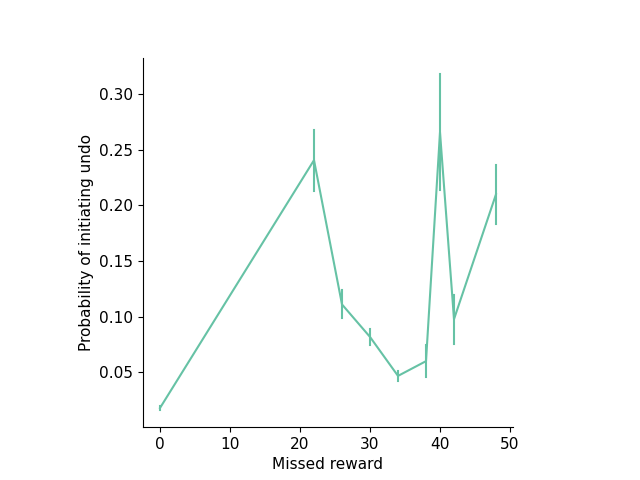

In [338]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='missed_reward', y='undo', 
             data = allUndo_sub[allUndo_sub.missed_reward<=50], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
# sns.lineplot(x='missed_reward', y='sequential_undo',
#              data = sequentialundo_sub,#[sequentialundo_sub.missed_reward<=32],
#              color = '#fc8d62',
#              err_style = "bars",
#              errorbar = "se")
# sns.lineplot(x='missed_reward', y='single_undo',
#                 data = singleUndo_sub,#[singleUndo_sub.missed_reward<=32],
#                 color = '#8da0cb',
#                 err_style = "bars",
#                 errorbar = "se")

# add manual legend
# plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

# axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Missed reward', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_missed_reward.png', dpi=300, bbox_inches='tight')

### Error rate

In [339]:
allUndo_sub = undo_error.groupby(['subjects','error_rate'])['undo'].mean().reset_index()
allUndo_sub.groupby(['error_rate'])['subjects'].count().reset_index()

error_rate  subjects
0     0.000000       100
1     0.090909        71
2     0.100000        93
3     0.111111        99
4     0.125000       100
5     0.142857       100
6     0.166667       100
7     0.200000       100
8     0.222222        46
9     0.250000       100
10    0.285714       100
11    0.333333       100
12    0.375000        29
13    0.400000        98
14    0.428571        64
15    0.500000       100
16    0.571429         5
17    0.600000        73
18    0.666667        98
19    0.714286         1
20    0.750000        65
21    0.800000        30
22    0.833333         3
23    1.000000        91
24    1.200000         1
25    1.250000         6
26    1.333333        32
27    1.500000        44
28    1.666667         5
29    2.000000        18
30    2.500000         3
31    3.000000         2

In [340]:
singleUndo_sub = undo_error.groupby(['subjects','error_rate'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['error_rate'])['subjects'].count().reset_index()

error_rate  subjects
0     0.000000       100
1     0.090909        71
2     0.100000        93
3     0.111111        99
4     0.125000       100
5     0.142857       100
6     0.166667       100
7     0.200000       100
8     0.222222        46
9     0.250000       100
10    0.285714       100
11    0.333333       100
12    0.375000        29
13    0.400000        98
14    0.428571        64
15    0.500000       100
16    0.571429         5
17    0.600000        73
18    0.666667        98
19    0.714286         1
20    0.750000        65
21    0.800000        30
22    0.833333         3
23    1.000000        91
24    1.200000         1
25    1.250000         6
26    1.333333        32
27    1.500000        44
28    1.666667         5
29    2.000000        18
30    2.500000         3
31    3.000000         2

In [341]:
sequentialundo_sub = undo_error.groupby(['subjects','error_rate'])['sequential_undo'].mean().reset_index()
sequentialundo_sub.groupby(['error_rate'])['subjects'].count().reset_index()

error_rate  subjects
0     0.000000       100
1     0.090909        71
2     0.100000        93
3     0.111111        99
4     0.125000       100
5     0.142857       100
6     0.166667       100
7     0.200000       100
8     0.222222        46
9     0.250000       100
10    0.285714       100
11    0.333333       100
12    0.375000        29
13    0.400000        98
14    0.428571        64
15    0.500000       100
16    0.571429         5
17    0.600000        73
18    0.666667        98
19    0.714286         1
20    0.750000        65
21    0.800000        30
22    0.833333         3
23    1.000000        91
24    1.200000         1
25    1.250000         6
26    1.333333        32
27    1.500000        44
28    1.666667         5
29    2.000000        18
30    2.500000         3
31    3.000000         2

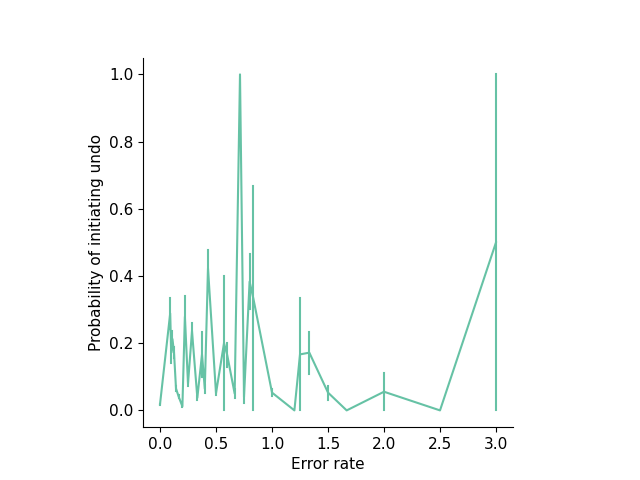

In [342]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='error_rate', y='undo', 
             data = allUndo_sub,#[allUndo_sub.missed_reward<=30], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
# sns.lineplot(x='error_rate', y='sequential_undo',
#              data = sequentialundo_sub,#[sequentialundo_sub.missed_reward<=32],
#              color = '#fc8d62',
#              err_style = "bars",
#              errorbar = "se")
# sns.lineplot(x='error_rate', y='single_undo',
#                 data = singleUndo_sub,#[singleUndo_sub.missed_reward<=32],
#                 color = '#8da0cb',
#                 err_style = "bars",
#                 errorbar = "se")

# add manual legend
# plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

# axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Error rate', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_error_rate.png', dpi=300, bbox_inches='tight')

### Cumulative error

In [343]:
allUndo_sub = undo_error.groupby(['subjects','cumulative_error'])['undo'].mean().reset_index()
allUndo_sub.groupby(['cumulative_error'])['subjects'].count().reset_index()

cumulative_error  subjects
0                 0       100
1                 1       100
2                 2       100
3                 3        81
4                 4        42
5                 5         8
6                 6         3
7                 8         1

In [344]:
singleUndo_sub = undo_error.groupby(['subjects','cumulative_error'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['cumulative_error'])['subjects'].count().reset_index()

cumulative_error  subjects
0                 0       100
1                 1       100
2                 2       100
3                 3        81
4                 4        42
5                 5         8
6                 6         3
7                 8         1

In [345]:
sequentialundo_sub = undo_error.groupby(['subjects','cumulative_error'])['sequential_undo'].mean().reset_index()
sequentialundo_sub.groupby(['cumulative_error'])['subjects'].count().reset_index()

cumulative_error  subjects
0                 0       100
1                 1       100
2                 2       100
3                 3        81
4                 4        42
5                 5         8
6                 6         3
7                 8         1

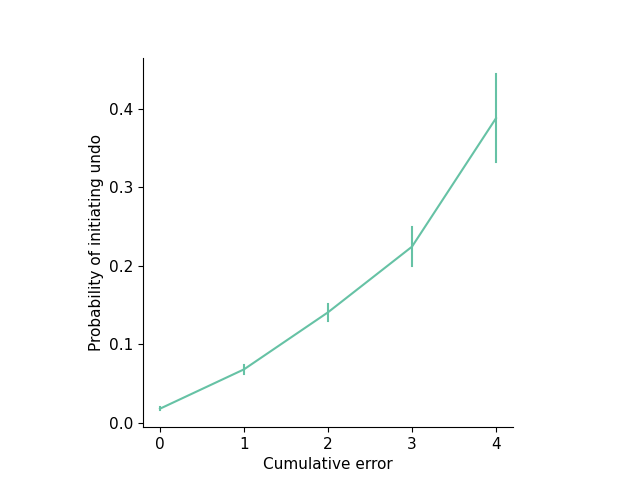

In [346]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='undo', 
             data = allUndo_sub[allUndo_sub.cumulative_error<=4], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
# sns.lineplot(x='cumulative_error', y='sequential_undo',
#              data = sequentialundo_sub[sequentialundo_sub.cumulative_error<=4],
#              color = '#fc8d62',
#              err_style = "bars",
#              errorbar = "se")
# sns.lineplot(x='cumulative_error', y='single_undo',
#                 data = singleUndo_sub[singleUndo_sub.cumulative_error<=4],
#                 color = '#8da0cb',
#                 err_style = "bars",
#                 errorbar = "se")

# add manual legend
# plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

# axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)


axs.set(xlabel='Cumulative error', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_cumulativeerror.png', dpi=300, bbox_inches='tight')

## Possible cues for error correction

In [189]:
# na can happen in branching_RT because there may be "fake undo"
def filter_dataframe(df, col1_list, col2_list):
    RT1 = []
    RT_branching = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            RT1.append(float(temp.loc[:,"RT1"].values))
            RT_branching.append(float(temp.loc[:,"RT_branching"].values))
        if temp.empty:
            RT1.append(np.nan)
            RT_branching.append(np.nan)
    return RT1, RT_branching

def filter_dataframe_TT(df, col1_list, col2_list):
    TT = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            TT.append(float(temp.loc[:,"TT"].values))
        if temp.empty:
            TT.append(np.nan)
    return TT

In [191]:
def preprocess_data(df, condition_col, condition_val):
    # Filter based on condition
    df_filtered = df[df[condition_col] == condition_val].copy()
    # Adjust indices for looking up "before" rows
    df_before = df.loc[df_filtered.index - 1].copy()
    # Identify end of the action
    index_end = df_before.index[(df_before['checkEnd'] == 1)] # &(df_before['cumulative_error'] == 0)
    # Extract relevant state information
    state = df_before.loc[index_end, ['leftover', 'allMAS', 'subjects', 'puzzleID', 'cumulative_error', "currNumCities"]]
    # Add additional information from the next row
    state['lastRT'] = df.loc[index_end + 1, 'RT'].values
    state['lastRT_log'] = np.log(state['lastRT'] / 1000 + 1)
    # Remove duplicates
    # state = state.drop_duplicates()

    return state

def add_response_times(state, single_condition_data, puzzleID_order_data):
    subjects = list(state['subjects'])
    puzzleID = list(state['puzzleID'])
    # Optimize the filter_dataframe and filter_dataframe_TT functions as previously discussed
    RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
    TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition'] == 0], subjects, puzzleID)
    state["RT1"] = RT1
    state["RT_branching"] = RT_branching
    state["TT"] = TT
    return state

# Process 'undo' and 'not undo' states
state_undo = preprocess_data(sc_data_choice_level, 'firstUndo', 1)
state_undo = add_response_times(state_undo, single_condition_data, puzzleID_order_data)
state_undo['firstUndo'] = 1

state_notundo = preprocess_data(sc_data_choice_level, 'submit', 1)
state_notundo = add_response_times(state_notundo, single_condition_data, puzzleID_order_data)
state_notundo['firstUndo'] = 0

# only use those which directly submit
# state_notundo = state_notundo[~(state_notundo['subjects'].isin(state_undo['subjects']) & state_notundo['puzzleID'].isin(state_undo['puzzleID']))]

# Combine and process final DataFrame
state_df = pd.concat([state_undo, state_notundo]).reset_index(drop=True)

# Binning 'leftover' into bins
temp,cutoff = pd.cut(state_df['leftover'], bins=[0, 7, 14, 21, 28, 35, 42, 126], labels=range(1, 8), retbins=True)
state_df['leftover_bin'] = temp
state_df['error'] = state_df['cumulative_error'] > 0


### People indeed undo from optimal state

In [192]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                 'mas_gain':mas_gain})])


In [193]:
mas_gain_df_sub = mas_gain_df.groupby(['subjects','cum_error_beginning']).count().reset_index()
mas_gain_df_sub.groupby(['cum_error_beginning'])['subjects'].count().reset_index()

cum_error_beginning  subjects
0                    0        72
1                    1        82
2                    2        82
3                    3        58
4                    4        31
5                    5         4
6                    6         1

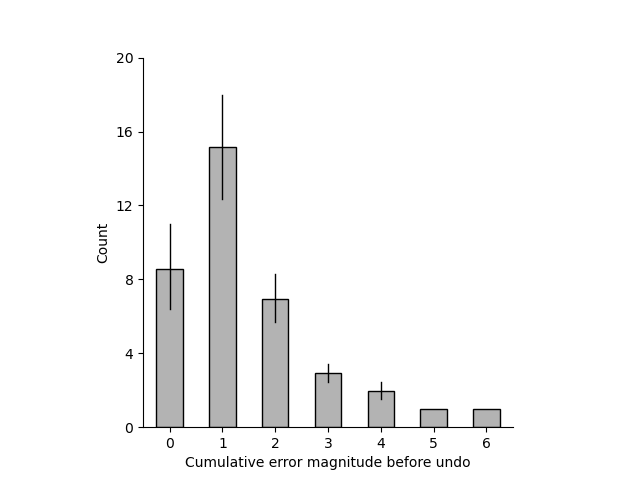

In [194]:
# plot accu_error_sub as sns barplot
%matplotlib widget

fig, axs = plt.subplots(1,1)
sns.barplot(x = 'cum_error_beginning', y = 'puzzleID', data = mas_gain_df_sub, 
            color = [.7,.7,.7],
            width=.5, linewidth=1,
            # error bar parameters
            errwidth = 1,
            errcolor = 'k',
            edgecolor = 'k',
            ax = axs)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Count')
# reset y axis tick
axs.set_yticks(range(0,24,4))

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'count_cumulative_error.png', dpi=300, bbox_inches='tight')


### puzzleMAS in a puzzle

In [197]:
firstUndo_sub = state_df.groupby(['subjects','currNumCities','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['currNumCities','error'])['firstUndo'].count()

currNumCities  error
2              True       4
3              True      13
4              True      46
5              True      87
6              False     89
               True      99
7              False     70
               True     100
8              False     98
               True      99
9              False     98
               True      80
10             False     91
               True      71
11             False     62
Name: firstUndo, dtype: int64

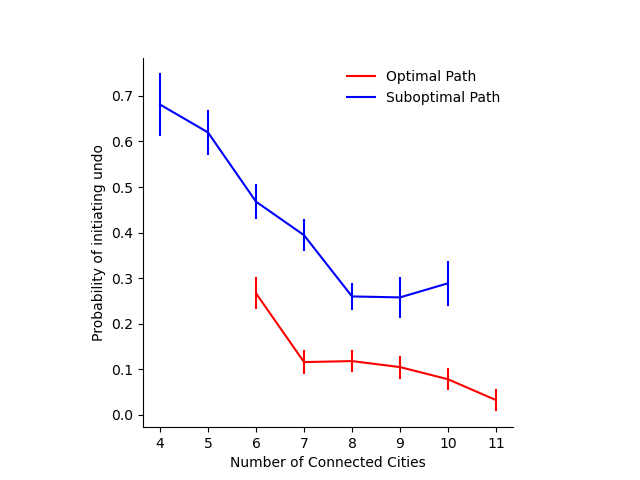

In [203]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.currNumCities>=4],
             hue = 'error',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Optimal Path','Suboptimal Path'], loc='upper right')
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_MAS.png', dpi=300, bbox_inches='tight')
plt.show()

In [204]:
error_sub = state_df.groupby(['subjects','currNumCities'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['currNumCities'])['cumulative_error'].count()

currNumCities
2       4
3      13
4      46
5      87
6      99
7     100
8      99
9      99
10     96
11     62
Name: cumulative_error, dtype: int64

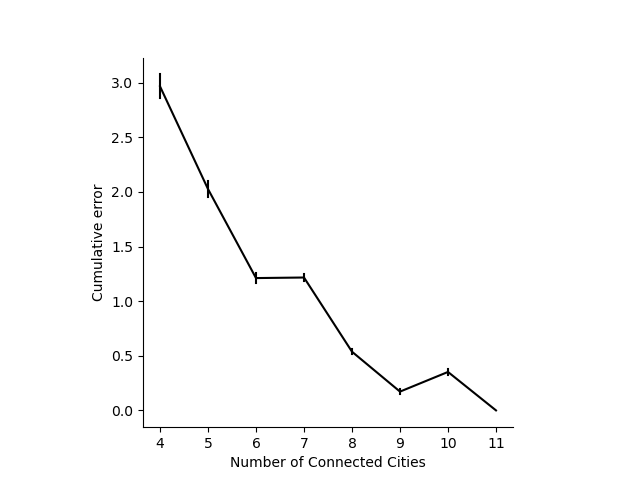

In [205]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='cumulative_error', 
             data = error_sub[error_sub.currNumCities>=4],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Number of Connected Cities', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_mas.png', dpi=300, bbox_inches='tight')
plt.show()

#### Check total RT confound (supp)

In [356]:
TT_sub = state_df.groupby(['subjects','currNumCities'])['TT'].mean().reset_index()
TT_sub.groupby(['currNumCities'])['TT'].count()

currNumCities
2       4
3      13
4      46
5      87
6      99
7     100
8      99
9      99
10     96
11     62
Name: TT, dtype: int64

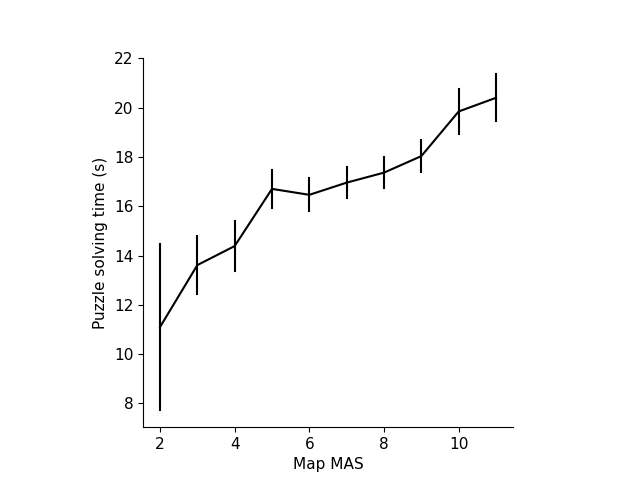

In [357]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='TT', data = TT_sub, color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Map MAS', ylabel='Puzzle solving time (s)')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'TT_achieved_score.png', dpi=300, bbox_inches='tight')

In [358]:
%%R -i state_df,out_dir2
state_df$subjects <- as.factor(state_df[,"subjects"])
state_df$TT_new <- state_df[,"TT"]^(0.5)

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + TT_new + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_TT.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

/Users/dbao/opt/anaconda3/envs/road/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "leftover_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


AttributeError: 'int' object has no attribute 'encode'

### Remaining budget

In [360]:
firstUndo_sub = state_df.groupby(['subjects','leftover_bin', 'error'])['firstUndo'].mean().reset_index()
# count ignore nan
firstUndo_sub.groupby(['leftover_bin', 'error'])['firstUndo'].count()

leftover_bin  error
1             False     97
              True      95
2             False     98
              True      98
3             False     96
              True      99
4             False     95
              True      98
5             False     56
              True      97
6             False     31
              True      93
7             False      0
              True     100
Name: firstUndo, dtype: int64

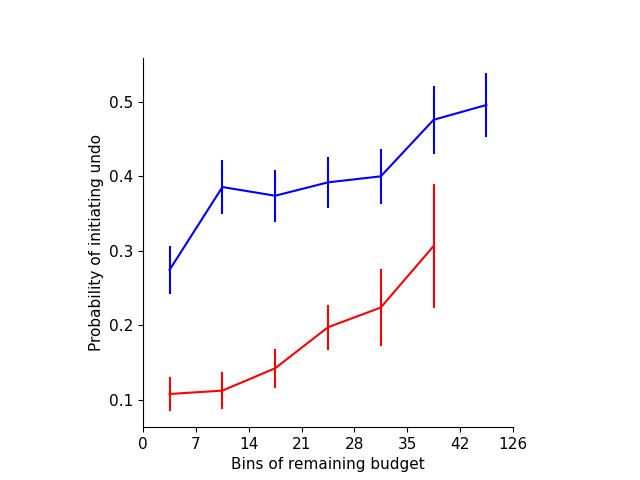

In [365]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.leftover_bin<=7],
             hue = 'error',
                palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff)
# hide legend
axs.get_legend().remove()
# axs.set_ylim(0,0.6)
axs.set(xlabel='Bins of remaining budget', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budget.png', dpi=300, bbox_inches='tight')
plt.show()

In [362]:
error_sub = state_df.groupby(['subjects','leftover_bin'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['leftover_bin'])['cumulative_error'].count()

leftover_bin
1     99
2     99
3     99
4     99
5     99
6     93
7    100
Name: cumulative_error, dtype: int64

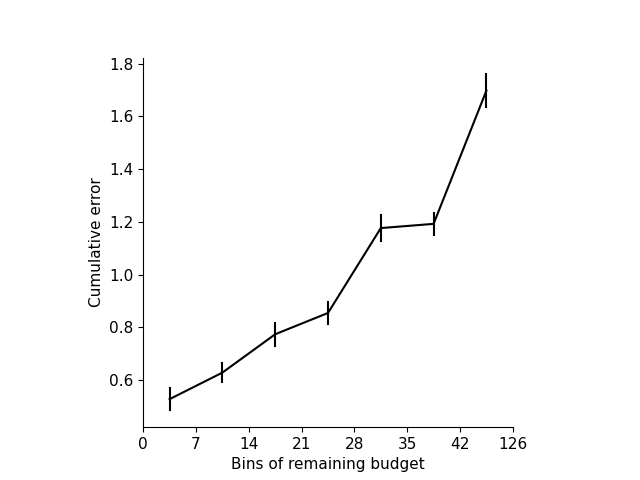

In [363]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='cumulative_error', 
             data = error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff)
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of remaining budget', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_leftover.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
spearmanr(state_df['leftover'], state_df['currNumCities'])

SpearmanrResult(correlation=-0.0778188560543579, pvalue=0.005396443586058339)

In [ ]:
%%R -i state_df,out_dir2
state_df$subjects <- as.factor(state_df[,"subjects"])
state_df$TT_new <- state_df[,"TT"]^(0.5)
state_df$leftover_new <- state_df[,"leftover"]^(0.3)

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + leftover_new + TT_new + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_TT_budget.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + leftover_new + TT_new + (1 |  
    subjects)
   Data: state_df

     AIC      BIC   logLik deviance df.resid 
   352.5    378.3   -171.3    342.5     1272 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1928 -0.0172 -0.0021  0.0081  4.8372 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 134.6    11.6    
Number of obs: 1277, groups:  subjects, 99

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     6.3250     3.0795   2.054    0.040 *  
currNumCities  -2.4965     0.4100  -6.088 1.14e-09 ***
leftover_new    5.3295     0.8872   6.007 1.89e-09 ***
TT_new          0.3189     0.3514   0.908    0.364    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) crrNmC lftvr_
currNumCits -0.6

### Only cumulative error == 1

### Uncertainty

#### First-move RT

In [366]:
# for RT1 and RT_branching, use only the very first undo
    
# before undo
index_first_undo = data_subset_before1undo.index[(data_subset_before1undo['firstUndo'] == 1)] # submit
df_beforeUndo = data_subset_before1undo.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)] # there are no errors and  end of trial
state_undo_1undo = df_beforeUndo.loc[index_end_undo, ['subjects','puzzleID',"cumulative_error"]]

subjects_undo = list(df_beforeUndo.loc[index_end_undo,'subjects'])
puzzleID_undo = list(df_beforeUndo.loc[index_end_undo,'puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
RT1_basic,_ = filter_dataframe(puzzleID_order_data[puzzleID_order_data['condition']==0], subjects_undo, puzzleID_undo)
state_undo_1undo["RT1"] = RT1
state_undo_1undo["RT1_basic"] = RT1_basic
# take log of RT1 as a new column
state_undo_1undo["RT1_log"] = np.log(state_undo_1undo["RT1"]+1)
state_undo_1undo["RT1_basic_log"] = np.log(state_undo_1undo["RT1_basic"]+1)
state_undo_1undo["RT_branching"] = RT_branching
state_undo_1undo['firstUndo'] = 1

# before submit
index_notundo = data_subset_before1undo.index[(data_subset_before1undo['submit'] == 1)] # submit
df_notbeforeUndo = data_subset_before1undo.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)]
state_notundo_1undo = df_notbeforeUndo.loc[index_end_notundo,['subjects','puzzleID',"cumulative_error"]]

subjects = list(df_notbeforeUndo.loc[index_end_notundo,'subjects'])
puzzleID = list(df_notbeforeUndo.loc[index_end_notundo,'puzzleID'])
RT1, RT_branching = filter_dataframe(single_condition_data, subjects, puzzleID)
RT1_basic,_ = filter_dataframe(puzzleID_order_data[puzzleID_order_data['condition']==0], subjects, puzzleID)
state_notundo_1undo["RT1"] = RT1
state_notundo_1undo["RT1_basic"] = RT1_basic
state_notundo_1undo["RT1_log"] = np.log(state_notundo_1undo["RT1"]+1)
state_notundo_1undo["RT1_basic_log"] = np.log(state_notundo_1undo["RT1_basic"]+1)
state_notundo_1undo["RT_branching"] = RT_branching 
state_notundo_1undo['firstUndo'] = 0
state_notundo_1undo['submitRT'] = list(data_subset_before1undo.loc[index_end_notundo+1,'RT'])

state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1
state_df_1undo['rt1_bin'] = state_df_1undo['rt1_bin'].astype(int)
state_df_1undo = state_df_1undo.reset_index(drop=True)
max(state_df_1undo['rt1_bin'])
state_df_1undo['error'] = state_df_1undo['cumulative_error'] > 0


In [367]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin',"error"])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin',"error"])['firstUndo'].count()

rt1_bin  error
1        False    92
         True     92
2        False    97
         True     99
3        False    54
         True     66
4        False     8
         True     16
5        False     1
         True      4
Name: firstUndo, dtype: int64

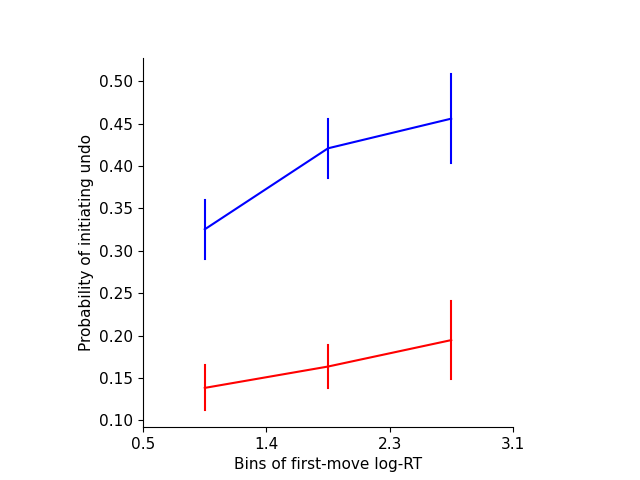

In [368]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             hue = "error",
                palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
#axs.set_xticks(np.arange(0.5, 7.5, 1))
# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
# hide legend
axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Bins of first-move log-RT', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [369]:
error_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['rt1_bin'])['cumulative_error'].count()

rt1_bin
1    98
2    99
3    74
4    22
5     4
Name: cumulative_error, dtype: int64

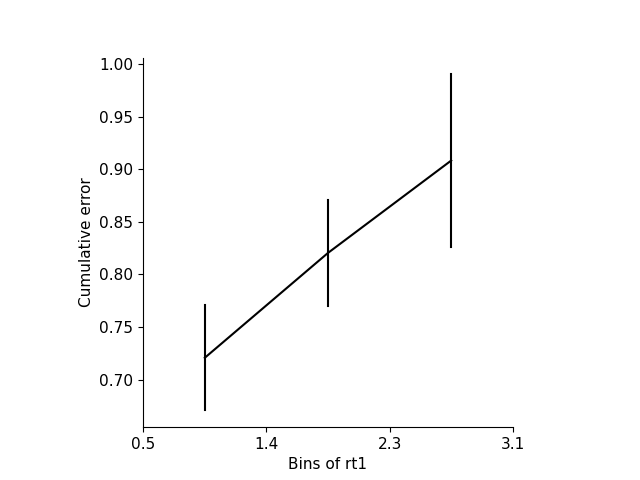

In [370]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='cumulative_error', 
             data = error_sub[error_sub.rt1_bin<=3],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of rt1', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log + (1 |subjects) + (1 |puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  1080.1   1102.2   -536.1   1072.1     1842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7849 -0.2659 -0.1166 -0.0472  6.9214 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.401    2.898   
 puzzleID (Intercept) 2.011    1.418   
Number of obs: 1846, groups:  subjects, 99; puzzleID, 45

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.5888     0.5844  -7.853 4.07e-15 ***
RT1_log       0.4237     0.2155   1.967   0.0492 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
RT1_log -0.598


In [ ]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_basic_log + (1 |subjects) + (1 |puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_basic_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  1083.3   1105.4   -537.7   1075.3     1842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3203 -0.2645 -0.1171 -0.0473  6.5258 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.461    2.909   
 puzzleID (Intercept) 2.057    1.434   
Number of obs: 1846, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.1847     0.5728  -7.305 2.77e-13 ***
RT1_basic_log   0.1570     0.1968   0.798    0.425    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
RT1_basc_lg -0.570


#### correlation with undoRT

In [ ]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['undoRT'].mean()))

SpearmanrResult(correlation=0.2908425359131318, pvalue=0.026767333235737715)


In [ ]:
print(spearmanr(state_notundo_1undo.groupby(['subjects'])['RT1'].mean() , state_notundo_1undo.groupby(['subjects'])['submitRT'].mean()))

SpearmanrResult(correlation=0.5315247624896146, pvalue=3.5447747051316746e-08)


# Undo completion

## Error before and after undo

In [ ]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','cum_error_end','error_beginning','error_rate_beginning','error_rate_end','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)
            error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
            error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        error_rate_end = list(df_undoTarget['error_rate'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        cum_error_end_list = []
        error_rate_end_list = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
            cum_error_end_list.append(accu_severity_error[i])
            error_rate_end_list.append(error_rate_end[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                               'cum_error_beginning':cum_error_beginning_list, 'cum_error_end':cum_error_end_list,
                                                               'error_beginning':error_beginning_list, 
                                                               'error_rate_beginning':error_rate_beginning_list,
                                                               'error_rate_end':error_rate_end_list,
                                                               'mas_gain':mas_gain})])


### Scatter plot

In [ ]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['cum_error_beginning','cum_error_end'].mean().reset_index()

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_34847/948503816.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['cum_error_beginning','cum_error_end'].mean().reset_index()


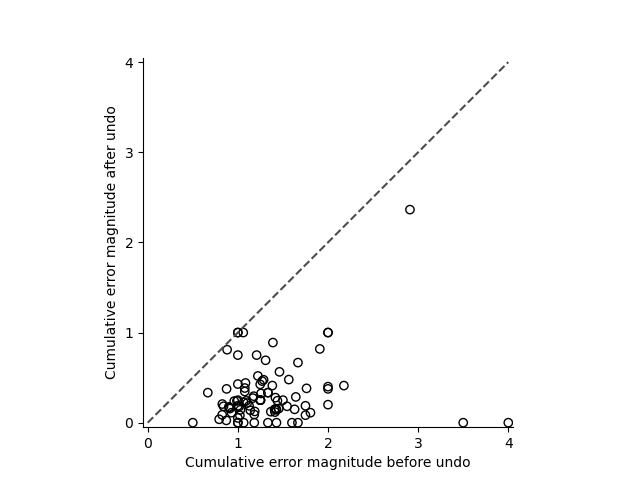

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='cum_error_beginning', y='cum_error_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 4], [0, 4], ls="--", c=".3")
ax1.set_xlim([-0.05,4.05])
ax1.set_ylim([-0.05,4.05])
ax1.set_xticks(np.arange(0, 4.5, 1))
ax1.set_yticks(np.arange(0, 4.5, 1))
ax1.set_xlabel("Cumulative error magnitude before undo")
ax1.set_ylabel("Cumulative error magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'error_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

0.5286900147100068
0.34279494095060203


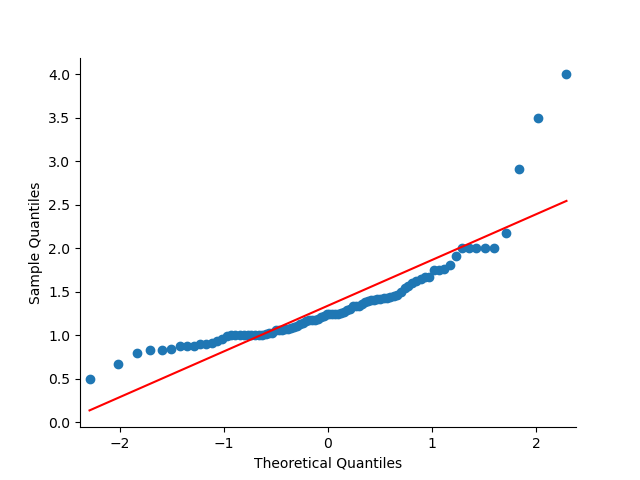

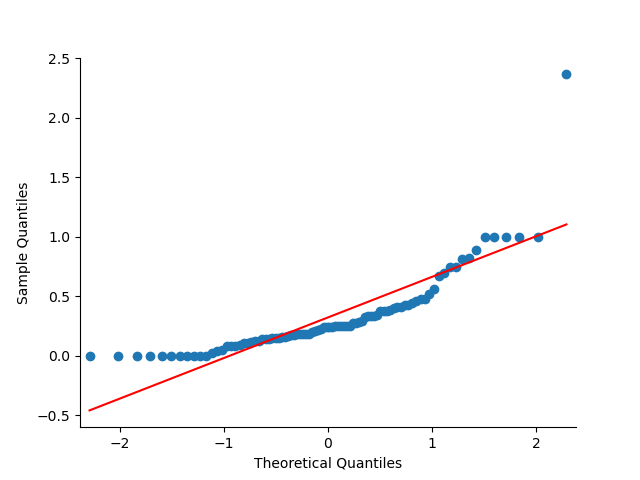

1.8266971276429214e-16


In [ ]:
cum_error_before = mas_gain_df.groupby(['subjects'])['cum_error_beginning'].mean()
cum_error_after = mas_gain_df.groupby(['subjects'])['cum_error_end'].mean()

# check equal variance ----
print(np.std(cum_error_before, ddof=1))
print(np.std(cum_error_after, ddof=1))

# check normality ----
sm.qqplot(cum_error_before, line='s')
py.show()
sm.qqplot(cum_error_after, line='s')
py.show()

stat1, p1 = wilcoxon(cum_error_before, cum_error_after, alternative = 'greater')
print(p1)

### Error rate

In [ ]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_df_sub

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3460544585.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


subjects  error_rate_beginning  error_rate_end
0          0              0.171176        0.015152
1          1              0.252847        0.113872
2          2              0.299482        0.055556
3          3              0.547619        0.000000
4          4              0.266478        0.084921
..       ...                   ...             ...
85        94              0.800000        0.000000
86        95              0.144901        0.091991
87        96              0.120201        0.011792
88        97              0.436508        0.166667
89        99              0.221322        0.049679

[90 rows x 3 columns]

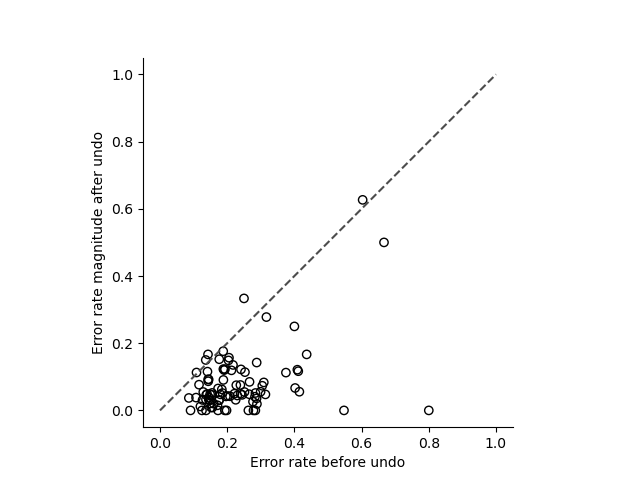

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='error_rate_beginning', y='error_rate_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 1], [0, 1], ls="--", c=".3")
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
# ax1.set_xticks(np.arange(0, 1.5, 1))
# ax1.set_yticks(np.arange(0, 1.5, 1))
ax1.set_xlabel("Error rate before undo")
ax1.set_ylabel("Error rate magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'errorrate_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

## Proportion of different undo result

In [ ]:
accu_error_3 = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1

            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0: # the state before first undo
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])

        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_3 = pd.concat([accu_error_3,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                 'category':category})])

accu_error_3["terminal"] = "notstart"

In [ ]:
# create empty dataframe
accu_error_2 = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level.loc[(sc_data_choice_level['subjects']==sub),:].sort_values(["puzzleID","index_copy"])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []

        dat_sbj_pzi = dat_sbj.loc[(dat_sbj['puzzleID'] == pzi),:].reset_index()    

        # last undo index when it is not the start city
        # only select rows when (dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi.lastUndo==1)&(dat_sbj_pzi.choice==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            
            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1

        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_2 = pd.concat([accu_error_2,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                 'category':category})])

accu_error_2["terminal"] = "start"

In [ ]:
# combine accu_error_2 and accu_error_3 into one dataframe
accu_error = pd.concat([accu_error_2,accu_error_3])
# calcualte the proportion of each category plus terminal, grouped by subjects
accu_error_p = accu_error.groupby(['category','terminal','subjects']).size().unstack(fill_value=0).apply(lambda x: x/x.sum())
accu_error_p = accu_error_p.T

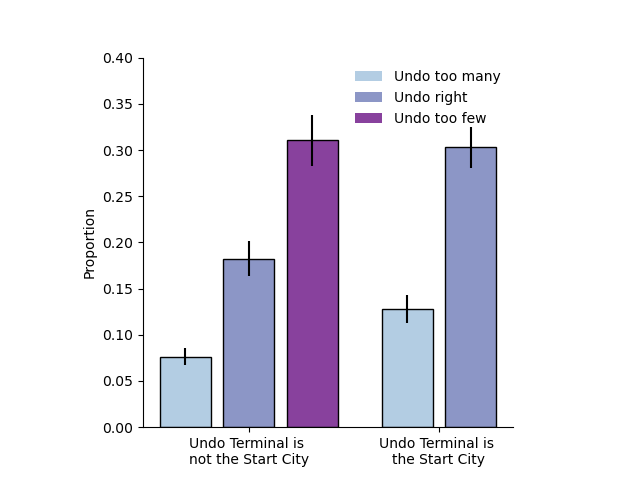

In [ ]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"],
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Proportion')
# 
axs.set_ylim([0,0.4])
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_completion type.png', dpi=300, bbox_inches='tight')

## what predicts the undo terminal

### cumulative error magnitude

In [ ]:
accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

subjects puzzleID cum_error_beginning error_beginning  \
0         0       28                   3               0   
0         1       15                   3               1   
0         1       18                   2               0   
0         1       30                   1               0   
0         1       38                   2               1   
..      ...      ...                 ...             ...   
1        99       17                   1               0   
0        99       24                   1               0   
0        99       29                   1               0   
0        99       31                   1               0   
0        99       41                   2               0   

    error_rate_beginning category  terminal  undo_right  undo_too_many  \
0               0.500000        0     start       False           True   
0               0.500000        1     start        True          False   
0               0.250000        1     start        True          False   
0               0.166667        1     start        True          False   
0               0.666667        1     start        True          False   
..                   ...      ...       ...         ...            ...   
1               0.142857        0  notstart       False           True   
0               0.333333        2  notstart       False          False   
0               0.125000        0  notstart       False           True   
0               0.111111        0  notstart       False           True   
0               0.250000        2  notstart       False          False   

    undo_too_few  
0          False  
0          False  
0          False  
0          False  
0          False  
..           ...  
1          False  
0           True  
0          False  
0          False  
0           True  

[2044 rows x 10 columns]

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['cum_error_beginning'])['undo_right'].count()

cum_error_beginning
1    82
2    82
3    58
4    31
5     4
6     1
Name: undo_right, dtype: int64

In [ ]:
accu_error

subjects puzzleID cum_error_beginning error_beginning category  terminal  \
0         0       28                   3               0        0     start   
0         1       15                   3               1        1     start   
0         1       18                   2               0        1     start   
0         1       30                   1               0        1     start   
0         1       38                   2               1        1     start   
..      ...      ...                 ...             ...      ...       ...   
1        99       17                   1               0        0  notstart   
0        99       24                   1               0        2  notstart   
0        99       29                   1               0        0  notstart   
0        99       31                   1               0        0  notstart   
0        99       41                   2               0        2  notstart   

    undo_right  undo_too_many  undo_too_few  
0        False           True         False  
0         True          False         False  
0         True          False         False  
0         True          False         False  
0         True          False         False  
..         ...            ...           ...  
1        False           True         False  
0        False          False          True  
0        False           True         False  
0        False           True         False  
0        False          False          True  

[2044 rows x 9 columns]

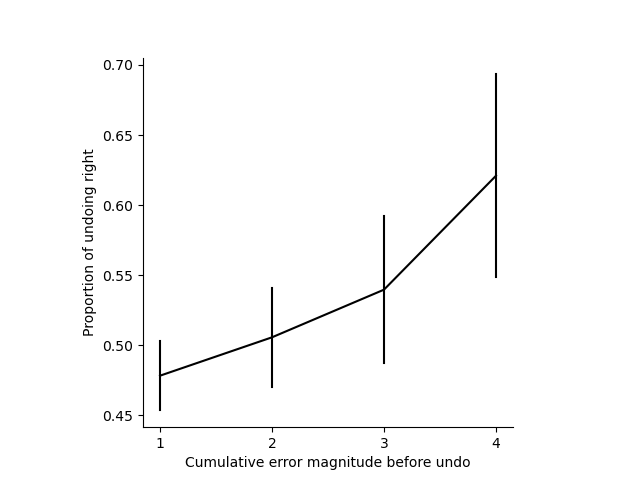

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='cum_error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_error.png', dpi=300, bbox_inches='tight')

In [ ]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])

model_undo_right = lme4::glmer(undo_right ~  1 + cum_error_beginning + (1 |subjects) ,
                                  data = accu_error[accu_error$cum_error_beginning<=4,], family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_cumulative_error.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + cum_error_beginning + (1 | subjects)
   Data: accu_error[accu_error$cum_error_beginning <= 4, ]

     AIC      BIC   logLik deviance df.resid 
  2761.6   2778.4  -1377.8   2755.6     2036 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6141 -0.9195 -0.5788  1.0049  2.0171 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2777   0.527   
Number of obs: 2039, groups:  subjects, 90

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.52904    0.12480  -4.239 2.25e-05 ***
cum_error_beginning  0.26863    0.06202   4.332 1.48e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn -0.771


### error magnitude before undo

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_beginning'])['undo_right'].count()

error_beginning
0    86
1    76
2    33
3    14
4     1
6     1
Name: undo_right, dtype: int64

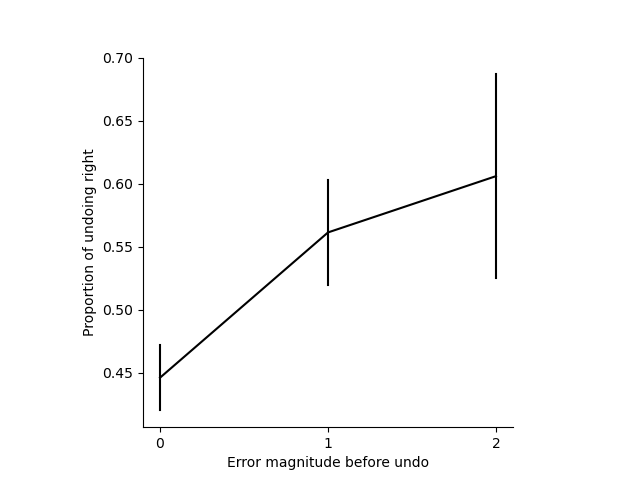

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.error_beginning<=2],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([0,1,2])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error.png', dpi=300, bbox_inches='tight')

In [ ]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)

model_undo_right = lme4::glmer(undo_right ~  1 + error_beginning + cum_error_beginning + (1 |subjects) ,
                                  data = accu_error[(accu_error$error_beginning<=2)&(accu_error$cum_error_beginning<=4),], 
                                  family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + error_beginning + cum_error_beginning + (1 |  
    subjects)
   Data: 
accu_error[(accu_error$error_beginning <= 2) & (accu_error$cum_error_beginning <=  
    4), ]

     AIC      BIC   logLik deviance df.resid 
  2664.8   2687.1  -1328.4   2656.8     1974 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8423 -0.8874 -0.5206  1.0139  1.9904 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2944   0.5426  
Number of obs: 1978, groups:  subjects, 90

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.10880    0.08209  -1.325  0.18507    
error_beginning      0.23900    0.07338   3.257  0.00112 ** 
cum_error_beginning  0.21226    0.05271   4.027 5.66e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Ef

### Error rate

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','error_rate_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_rate_beginning'])['undo_right'].count()

error_rate_beginning
0.090909    28
0.100000    28
0.111111    66
0.125000    70
0.142857    60
0.166667    54
0.200000    24
0.222222    16
0.250000    69
0.285714    62
0.333333    48
0.375000     6
0.400000    29
0.428571    35
0.500000    57
0.571429     1
0.600000    20
0.666667    19
0.714286     1
0.750000     7
0.800000    14
0.833333     1
1.000000    22
1.250000     1
1.333333     7
1.500000     6
2.000000     1
3.000000     1
Name: undo_right, dtype: int64

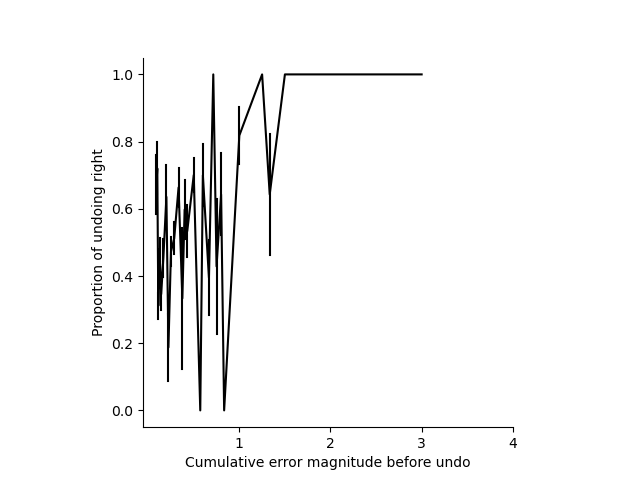

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_rate_beginning', y='undo_right',
                data = undo_right_sub,
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_errorrate.png', dpi=300, bbox_inches='tight')

## Correlations

## Metric 1: proportions

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_right_prop = accu_error.groupby(['subjects'])['undo_right'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_right_prop.index)]

spearmanr(score, undo_right_prop)

SpearmanrResult(correlation=-0.13312064506005297, pvalue=0.21100181575591548)

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_few_prop = accu_error.groupby(['subjects'])['undo_too_few'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_few_prop.index)]

spearmanr(score, undo_few_prop)

SpearmanrResult(correlation=0.1470036625195117, pvalue=0.16677864009093307)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_right_prop.index)]
spearmanr(balanced_accuracy, undo_right_prop)

SpearmanrResult(correlation=-0.033595457200651664, pvalue=0.7532566675233603)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_few_prop.index)]
spearmanr(balanced_accuracy, undo_few_prop)

SpearmanrResult(correlation=-0.06698676011526265, pvalue=0.5304532980708084)

## Metric 2: Error rate change

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, score)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3807902533.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.03115437580352458, pvalue=0.7706722334841731)

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, balanced_accuracy)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/2976432119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.0444307239747956, pvalue=0.6775415110542389)

## Metric 3: MAS gain

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(mas_gain.index)]
spearmanr(mas_gain, balanced_accuracy)

SpearmanrResult(correlation=-0.10919093542725634, pvalue=0.30561654498857593)

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(mas_gain.index)]
spearmanr(mas_gain, score)

SpearmanrResult(correlation=0.25321224856022057, pvalue=0.016040797773219848)